In [42]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 66.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 65.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pointpats 2.2.0 requires opencv-contrib-python>=4.2.0, which is not installed.
pysal 2.4.0 requires urllib3>=1.26, but you have urllib3 1.25.11 which is incompatible.


In [44]:
!pip install --upgrade numpy

  Using cached numpy-1.23.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pointpats 2.2.0 requires opencv-contrib-python>=4.2.0, which is not installed.
scipy 1.6.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.
pysal 2.4.0 requires urllib3>=1.26, but you have urllib3 1.25.11 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [36]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from google.cloud import storage
from pyspark.sql.functions import lit
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('Nifty50').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '30g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','30g'), ("spark.driver.maxResultSize", "70g")])

gcs_client = storage.Client()

In [3]:
bucket_name = 'new_bigdata_nifty50'

In [4]:
bucket = gcs_client.bucket(bucket_name)

In [5]:
file_name = 'df_with_indicators.csv'

In [6]:
df = spark.read.csv('gs://{}//{}'.format(bucket_name, file_name), inferSchema=True)

In [7]:
new_columns = ['date',
 'close',
 'high',
 'low',
 'open',
 'volume',
 'sma5',
 'sma10',
 'sma15',
 'sma20',
 'ema5',
 'ema10',
 'ema15',
 'ema20',
 'upperband',
 'middleband',
 'lowerband',
 'HT_TRENDLINE',
 'KAMA10',
 'KAMA20',
 'KAMA30',
 'SAR',
 'TRIMA5',
 'TRIMA10',
 'TRIMA20',
 'ADX5',
 'ADX10',
 'ADX20',
 'APO',
 'CCI5',
 'CCI10',
 'CCI15',
 'macd510',
 'macd520',
 'macd1020',
 'macd1520',
 'macd1226',
 'MFI',
 'MOM10',
 'MOM15',
 'MOM20',
 'ROC5',
 'ROC10',
 'ROC20',
 'PPO',
 'RSI14',
 'RSI8',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastksr',
 'fastdsr',
 'ULTOSC',
 'WILLR',
 'ATR',
 'Trange',
 'TYPPRICE',
 'HT_DCPERIOD',
 'BETA',
 'sector',
 'company',
 'Inflation Rate ',
 'Balance of Trade',
 'Bank Lending Rate',
 'Car Registrations',
 'Consumer Price Index',
 'Crude Oil Production',
 'Fiscal Expenditure',
 'Industrial Production',
 'Food Inflation',
 'Producer Prices',
 'Reverse Repo Rate',
 'Steel Production',
 'Tourist Arrivals',
 'Corporate Tax Rate ',
 'Export Prices',
 'GDP per Capita PPP',
 'GDP',
 'Gross National Product',
 'Import Prices',
 'Military Expenditure']

In [8]:
from functools import reduce

old_columns = df.schema.names
df = reduce(lambda data, idx: data.withColumnRenamed(old_columns[idx], new_columns[idx]), range(len(old_columns)), df)

In [9]:
cols = df.columns
cols.remove('company')
cols.remove('sector')

exprs = {x: "avg" for x in cols}
exprs['sector'] = 'first'
date_df = df.groupby(df.company, to_date(df.date).alias('day')).agg(exprs)

In [10]:
cols = df.columns
cols.remove('company')
cols.remove('sector')

exprs = {x: "avg" for x in cols}
exprs['sector'] = 'first'
date_df = df.groupby(df.company, to_date(df.date).alias('day')).agg(exprs)

In [11]:
w = Window.partitionBy('company').orderBy("day")
date_df = date_df.withColumn('diffClose', col("avg(close)") - lag(col("avg(close)")).over(w))

In [12]:
sum_df = date_df.groupby(df.company).agg(sum('diffClose').alias('totalChange'), first('first(sector)').alias('sector'))

In [13]:
w = Window.partitionBy('sector')
sector_df = sum_df.withColumn('maxtotalChange', max('totalChange').over(w))\
        .where(col('totalChange') == col('maxtotalChange'))\
        .drop('maxtotalChange')

In [14]:
sector_df = sector_df.toPandas()

In [15]:
top_companies_per_sector = list(sector_df['company'])
top_companies_per_sector.remove('NIFTY 50')
top_companies_per_sector.remove('NIFTY BANK')
top_companies_per_sector

['INDIGO',
 'ADANIENT',
 'MARUTI',
 'BHARTIARTL',
 'BAJFINANCE',
 'APOLLOHOSP',
 'ADANIGREEN',
 'LTI',
 'SHREECEM',
 'NESTLEIND',
 'SIEMENS',
 'LT',
 'RELIANCE',
 'DMART',
 'DLF',
 'PIIND',
 'ASIANPAINT']

In [26]:
top_companies_df = date_df.filter(date_df.company.isin(top_companies_per_sector)).toPandas()

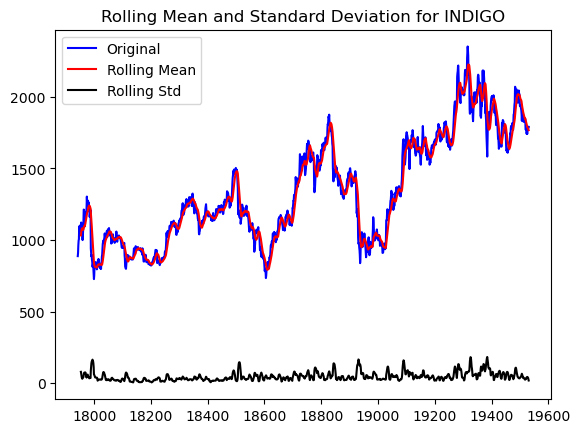

Results of dickey fuller test
Test Statistics                  -1.737789
p-value                           0.411755
No. of lags used                  9.000000
Number of observations used    1580.000000
critical value (1%)              -3.434496
critical value (5%)              -2.863371
critical value (10%)             -2.567745
dtype: float64


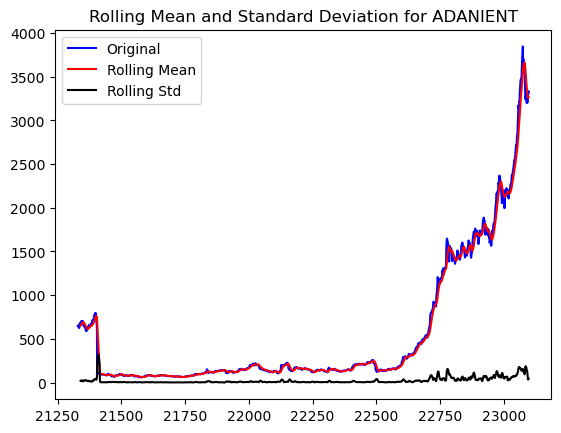

Results of dickey fuller test
Test Statistics                   2.935496
p-value                           1.000000
No. of lags used                 21.000000
Number of observations used    1747.000000
critical value (1%)              -3.434099
critical value (5%)              -2.863196
critical value (10%)             -2.567652
dtype: float64


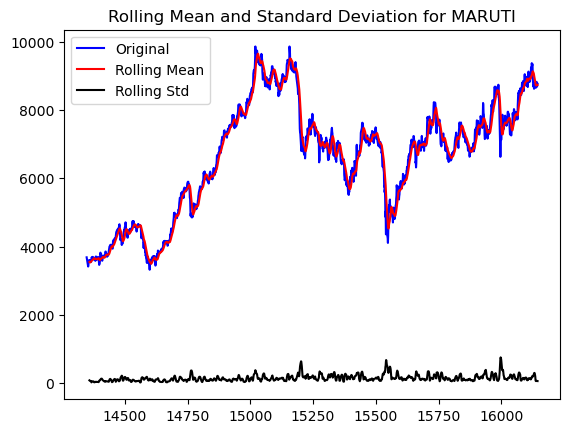

Results of dickey fuller test
Test Statistics                  -1.781028
p-value                           0.389921
No. of lags used                  9.000000
Number of observations used    1787.000000
critical value (1%)              -3.434015
critical value (5%)              -2.863159
critical value (10%)             -2.567632
dtype: float64


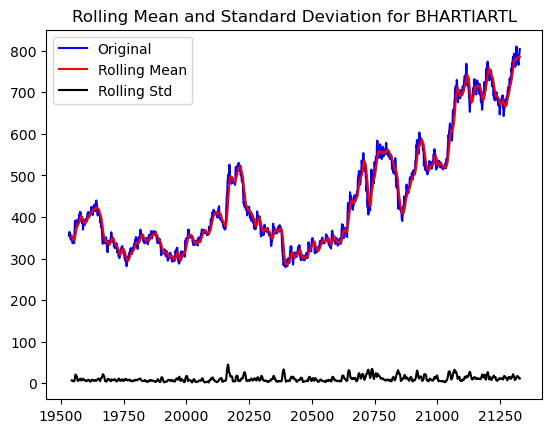

Results of dickey fuller test
Test Statistics                  -0.201060
p-value                           0.938395
No. of lags used                  1.000000
Number of observations used    1795.000000
critical value (1%)              -3.433998
critical value (5%)              -2.863152
critical value (10%)             -2.567628
dtype: float64


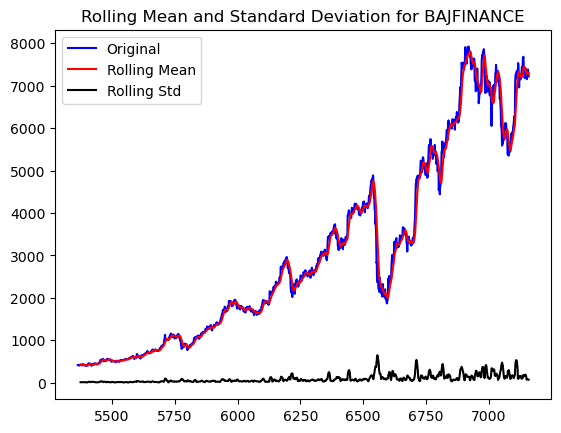

Results of dickey fuller test
Test Statistics                  -0.497503
p-value                           0.892503
No. of lags used                 10.000000
Number of observations used    1786.000000
critical value (1%)              -3.434017
critical value (5%)              -2.863160
critical value (10%)             -2.567632
dtype: float64


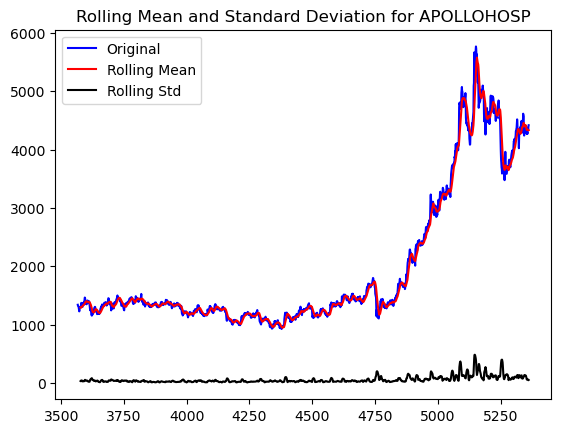

Results of dickey fuller test
Test Statistics                   0.338065
p-value                           0.979025
No. of lags used                 18.000000
Number of observations used    1778.000000
critical value (1%)              -3.434033
critical value (5%)              -2.863167
critical value (10%)             -2.567636
dtype: float64


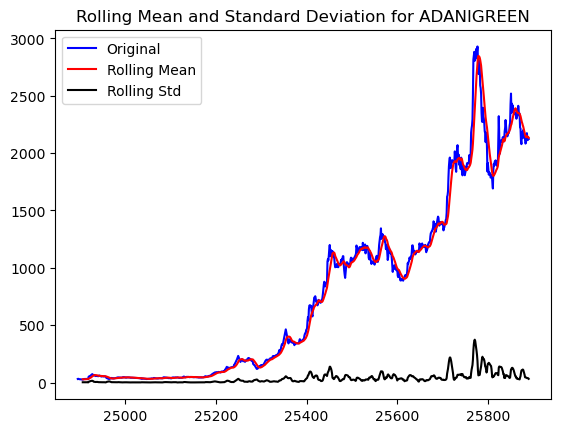

Results of dickey fuller test
Test Statistics                 -0.277376
p-value                          0.928648
No. of lags used                21.000000
Number of observations used    974.000000
critical value (1%)             -3.437082
critical value (5%)             -2.864512
critical value (10%)            -2.568352
dtype: float64


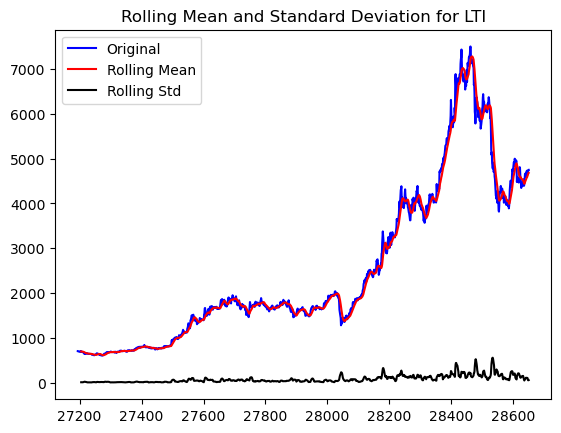

Results of dickey fuller test
Test Statistics                  -0.842076
p-value                           0.806449
No. of lags used                 23.000000
Number of observations used    1433.000000
critical value (1%)              -3.434922
critical value (5%)              -2.863559
critical value (10%)             -2.567845
dtype: float64


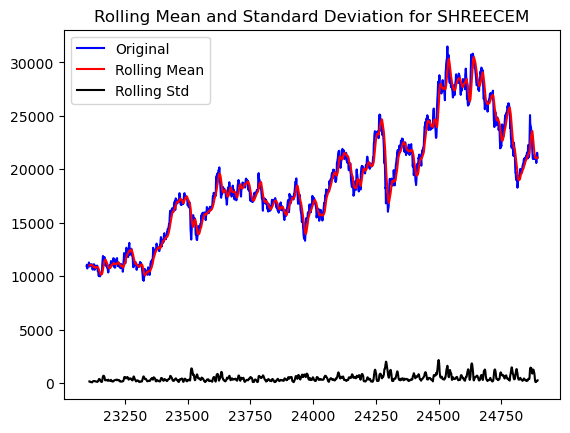

Results of dickey fuller test
Test Statistics                  -2.051256
p-value                           0.264561
No. of lags used                  2.000000
Number of observations used    1794.000000
critical value (1%)              -3.434000
critical value (5%)              -2.863152
critical value (10%)             -2.567628
dtype: float64


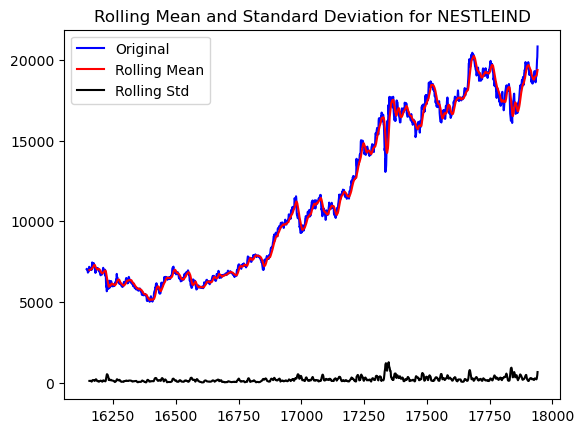

Results of dickey fuller test
Test Statistics                   0.089650
p-value                           0.965347
No. of lags used                  9.000000
Number of observations used    1787.000000
critical value (1%)              -3.434015
critical value (5%)              -2.863159
critical value (10%)             -2.567632
dtype: float64


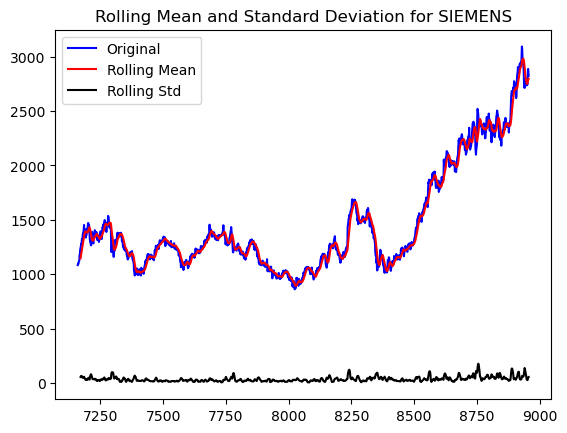

Results of dickey fuller test
Test Statistics                   0.134510
p-value                           0.968340
No. of lags used                  1.000000
Number of observations used    1795.000000
critical value (1%)              -3.433998
critical value (5%)              -2.863152
critical value (10%)             -2.567628
dtype: float64


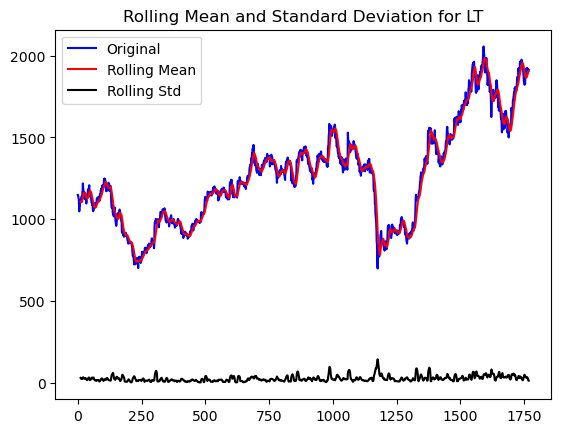

Results of dickey fuller test
Test Statistics                  -0.865986
p-value                           0.798967
No. of lags used                  2.000000
Number of observations used    1766.000000
critical value (1%)              -3.434058
critical value (5%)              -2.863178
critical value (10%)             -2.567642
dtype: float64


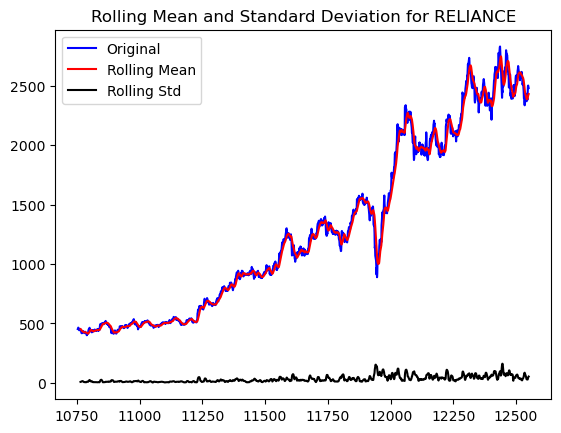

Results of dickey fuller test
Test Statistics                  -0.367526
p-value                           0.915381
No. of lags used                 23.000000
Number of observations used    1773.000000
critical value (1%)              -3.434044
critical value (5%)              -2.863172
critical value (10%)             -2.567639
dtype: float64


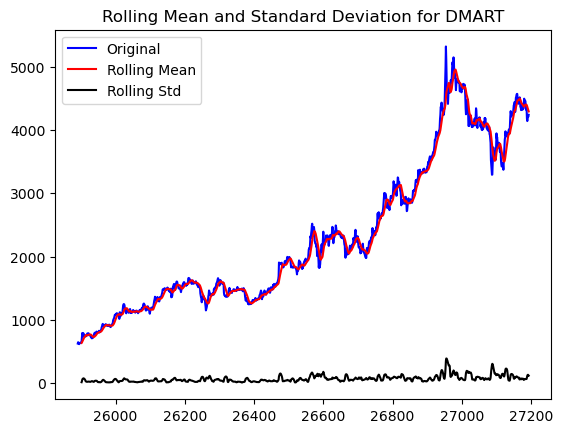

Results of dickey fuller test
Test Statistics                  -0.511339
p-value                           0.889785
No. of lags used                  7.000000
Number of observations used    1295.000000
critical value (1%)              -3.435410
critical value (5%)              -2.863774
critical value (10%)             -2.567960
dtype: float64


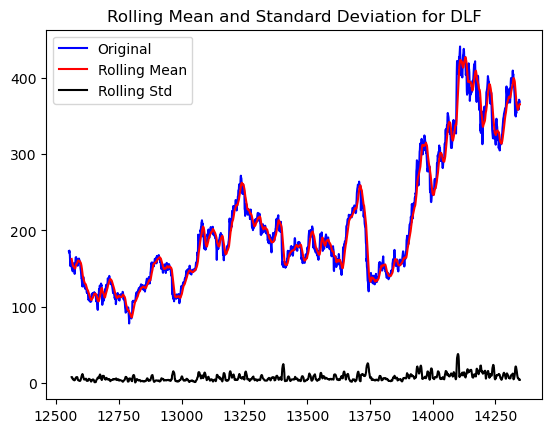

Results of dickey fuller test
Test Statistics                  -1.041000
p-value                           0.738018
No. of lags used                  8.000000
Number of observations used    1788.000000
critical value (1%)              -3.434013
critical value (5%)              -2.863158
critical value (10%)             -2.567631
dtype: float64


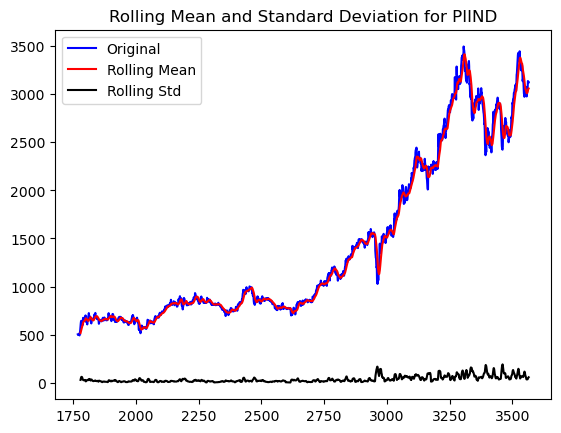

Results of dickey fuller test
Test Statistics                   0.031716
p-value                           0.961078
No. of lags used                  5.000000
Number of observations used    1791.000000
critical value (1%)              -3.434006
critical value (5%)              -2.863155
critical value (10%)             -2.567630
dtype: float64


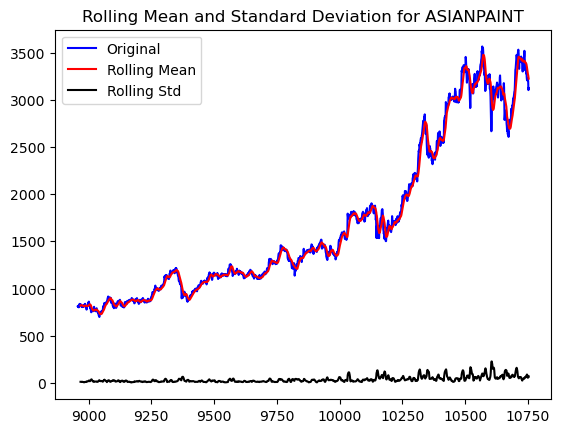

Results of dickey fuller test
Test Statistics                  -0.111569
p-value                           0.948274
No. of lags used                 20.000000
Number of observations used    1776.000000
critical value (1%)              -3.434037
critical value (5%)              -2.863169
critical value (10%)             -2.567637
dtype: float64


In [ ]:
import pandas as pd
def test_stationarity(timeseries, company):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation for {}'.format(company))
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

for company in top_companies_per_sector:
    test_stationarity(top_companies_df[top_companies_df['company']==company]['avg(close)'], company)

/tmp/ipykernel_8625/702561032.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(16, 9))


<Figure size 1600x900 with 0 Axes>

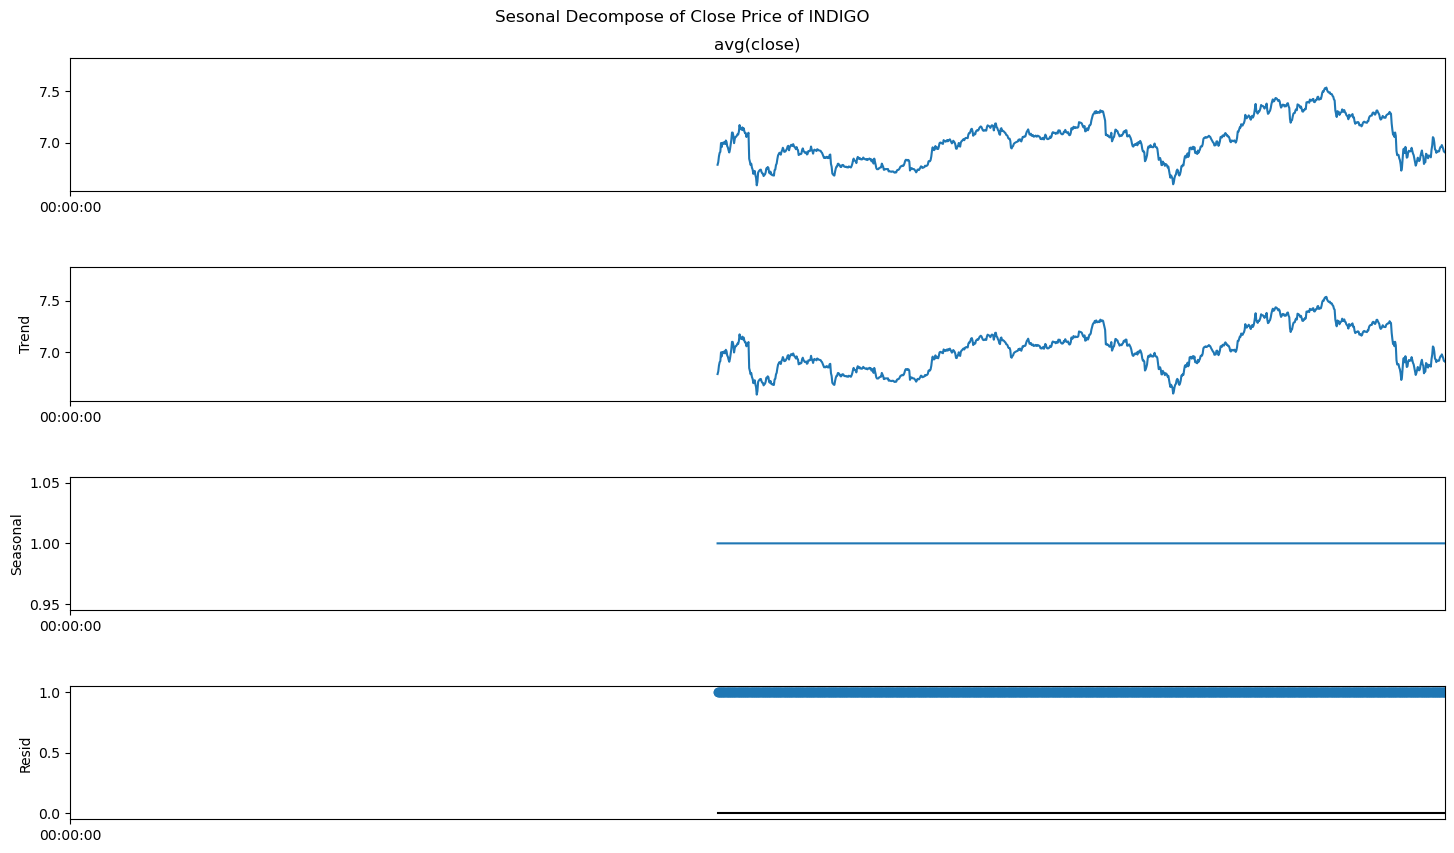

<Figure size 1600x900 with 0 Axes>

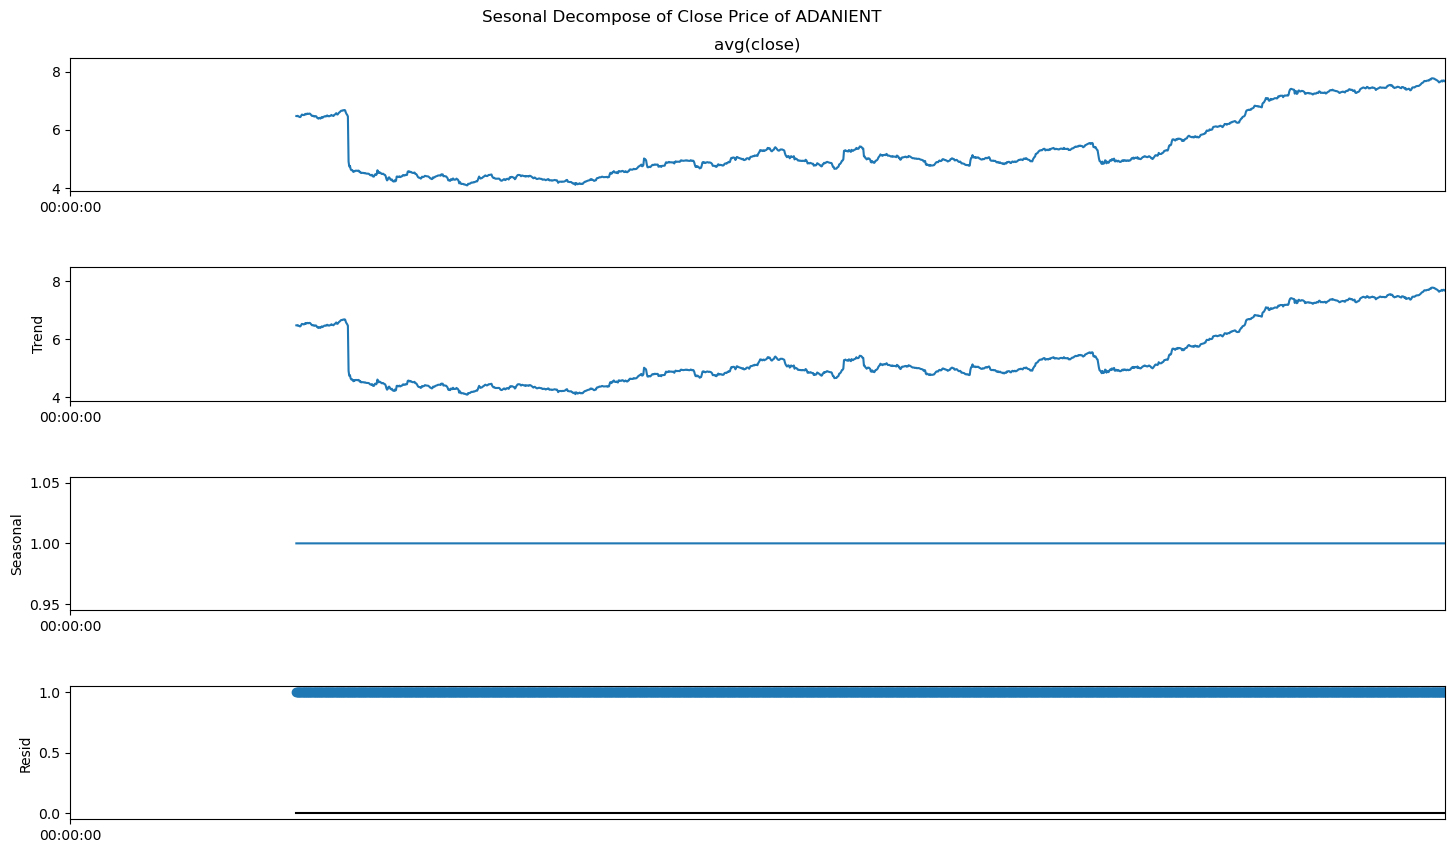

<Figure size 1600x900 with 0 Axes>

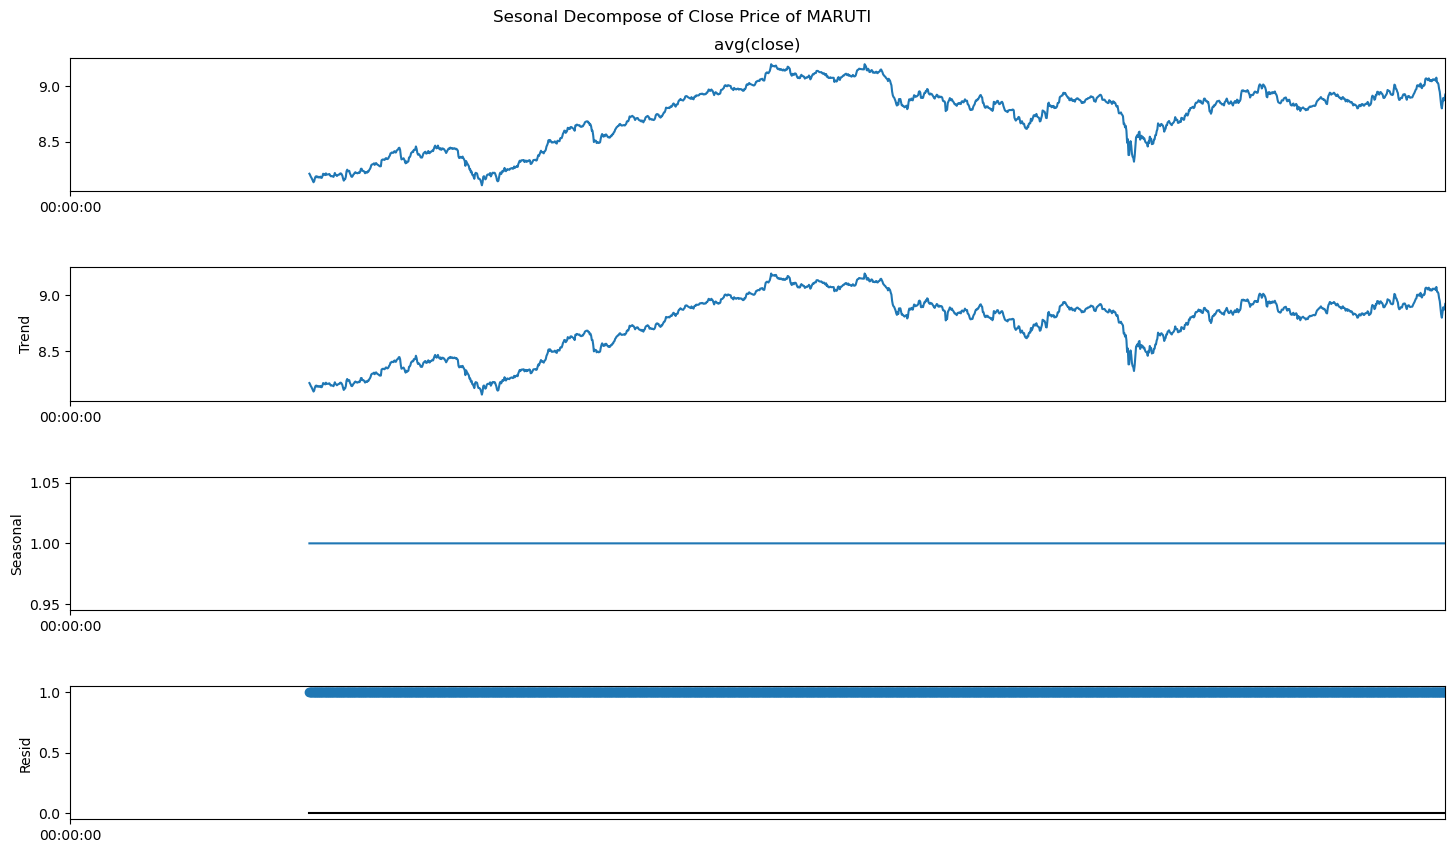

<Figure size 1600x900 with 0 Axes>

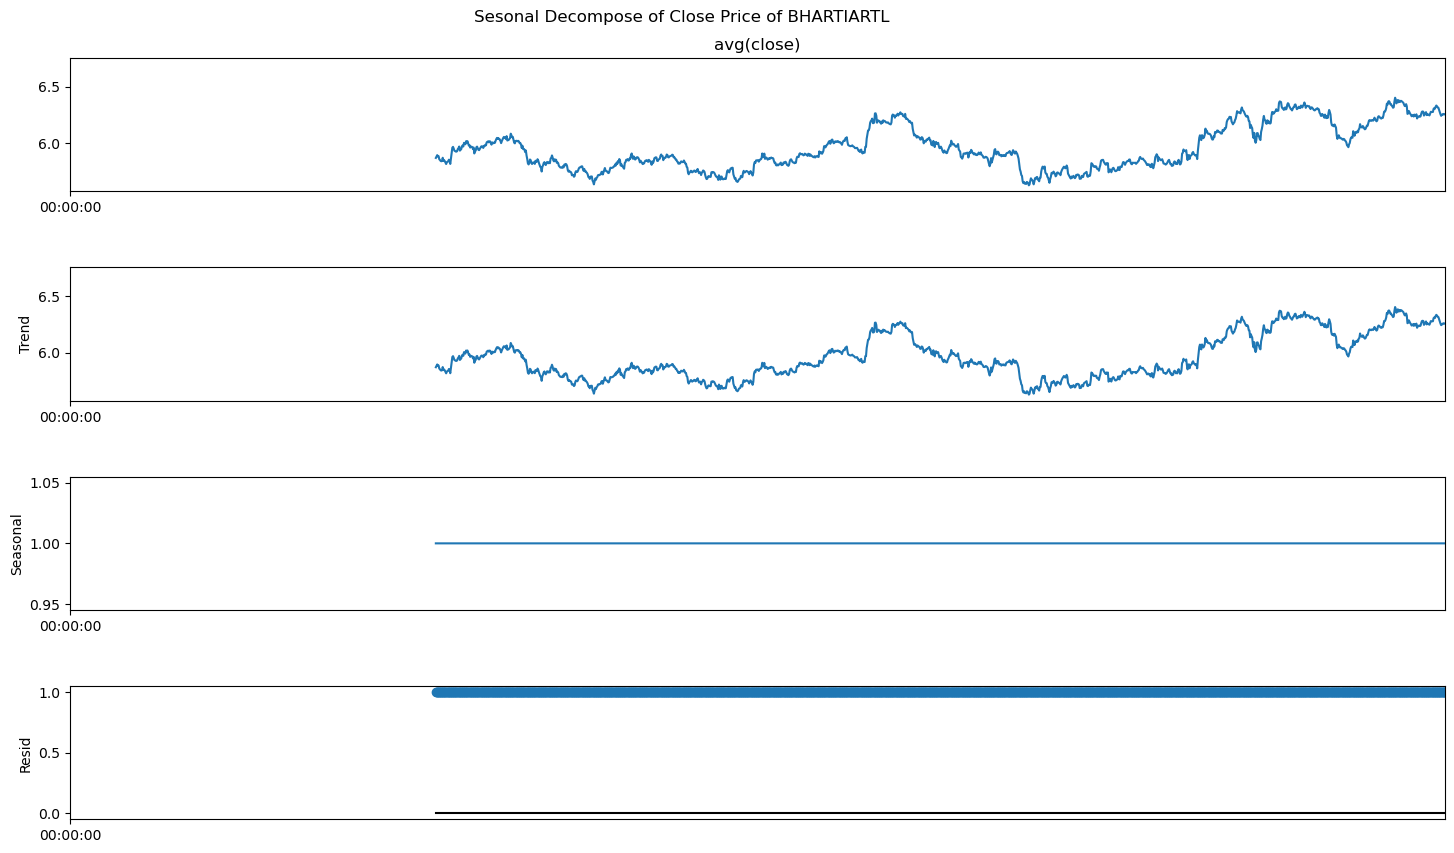

<Figure size 1600x900 with 0 Axes>

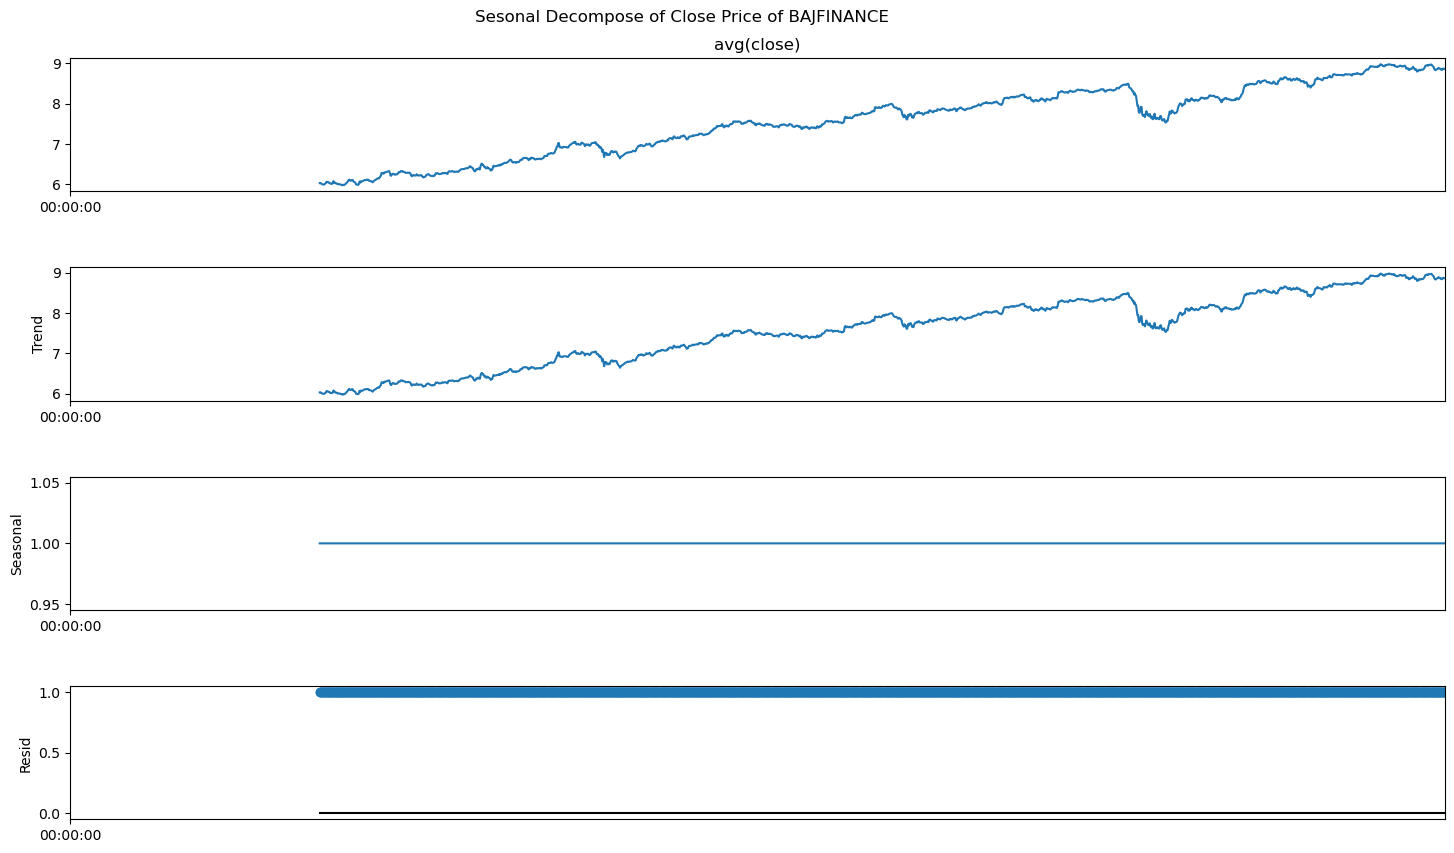

<Figure size 1600x900 with 0 Axes>

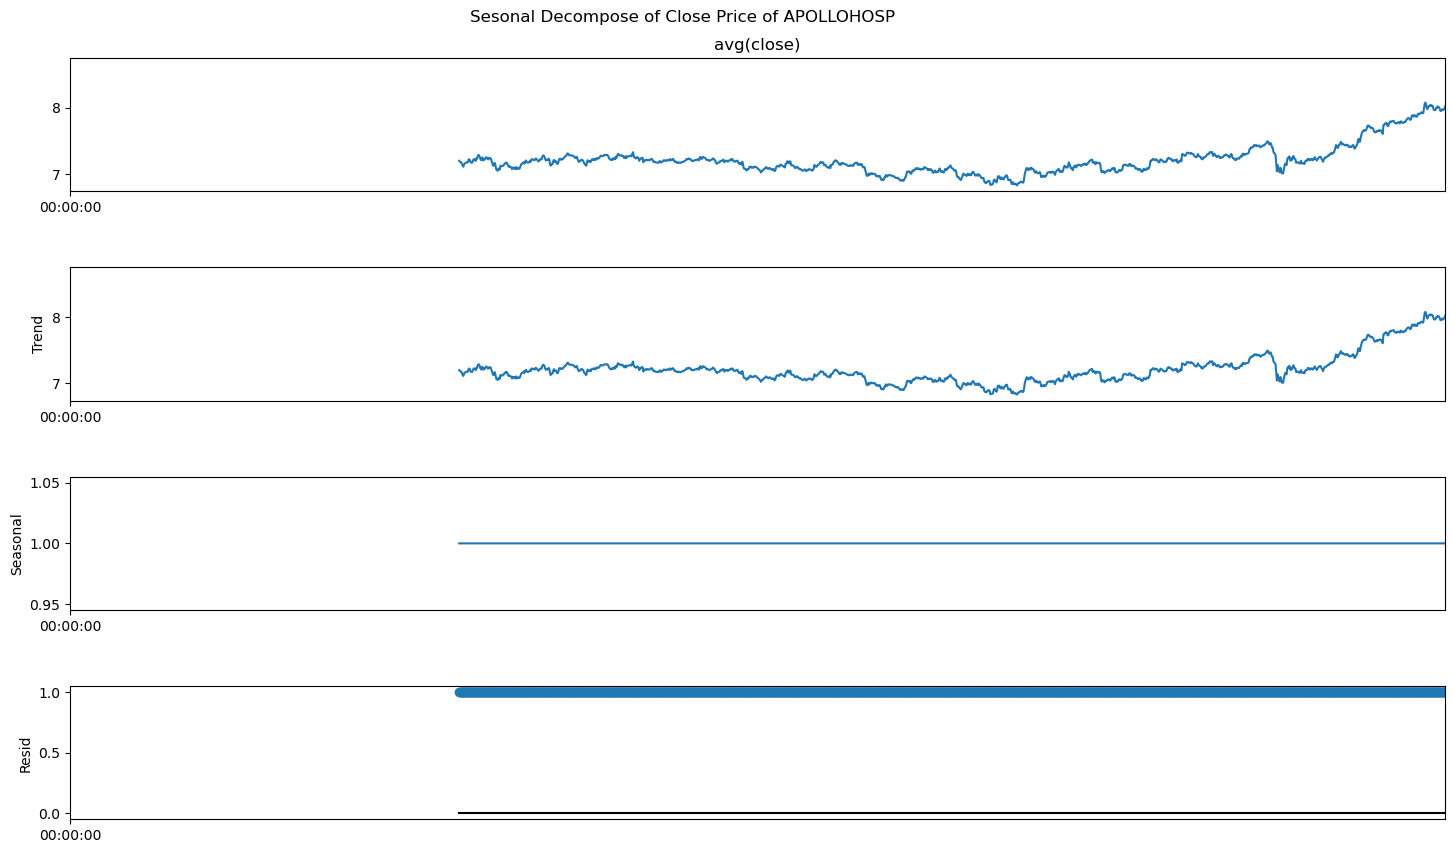

<Figure size 1600x900 with 0 Axes>

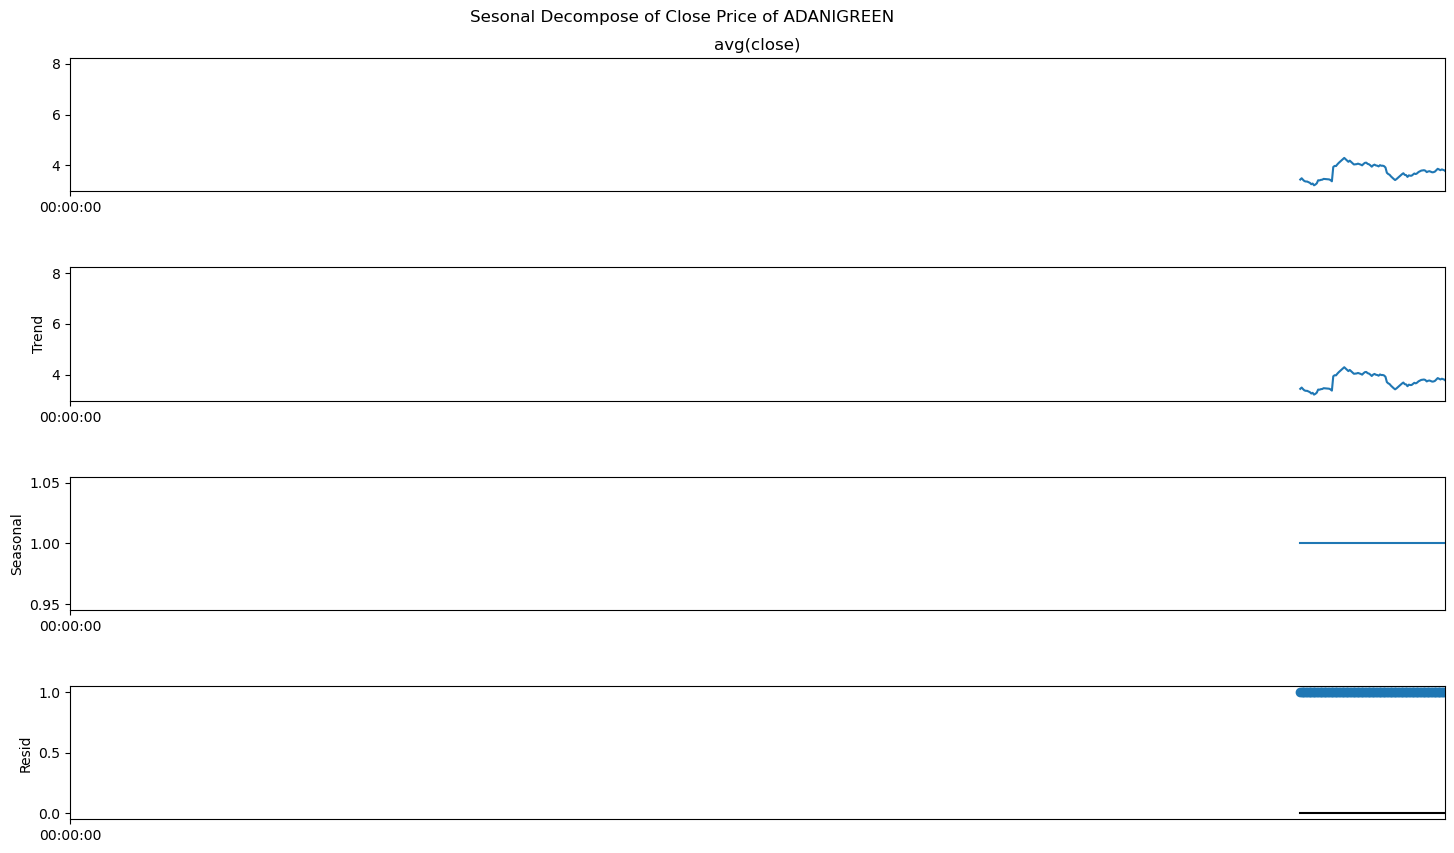

<Figure size 1600x900 with 0 Axes>

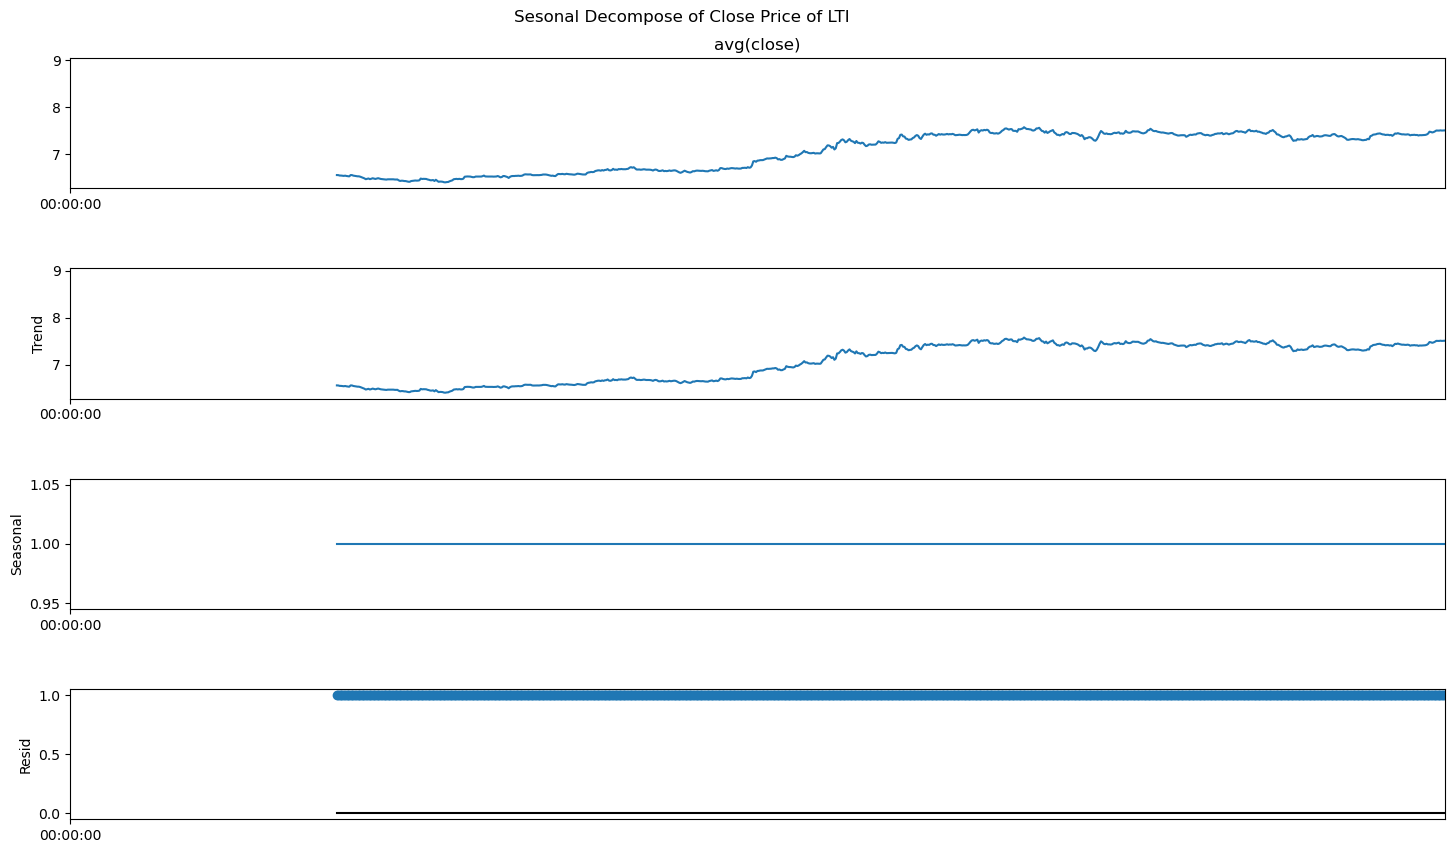

<Figure size 1600x900 with 0 Axes>

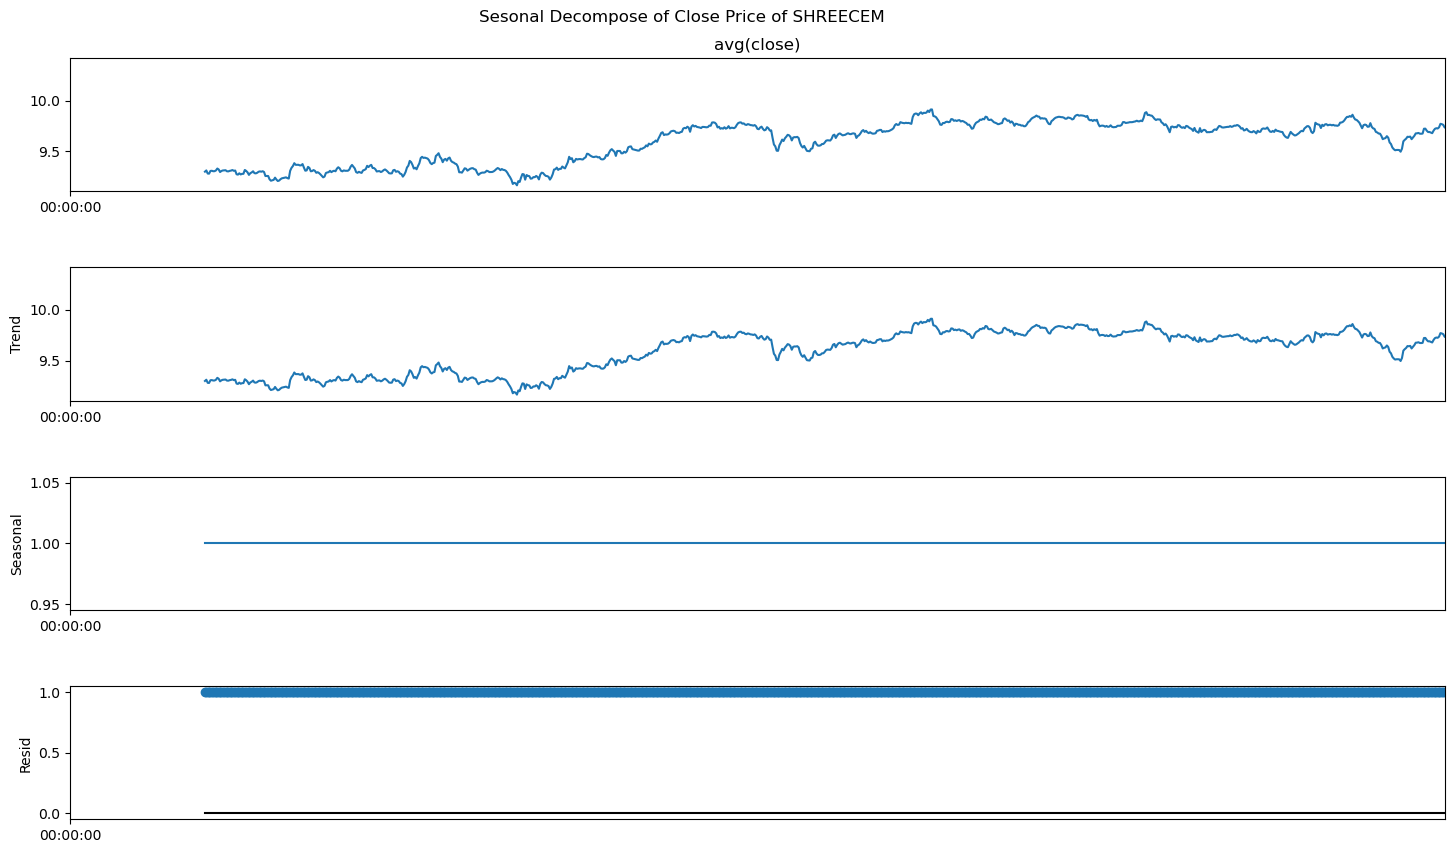

<Figure size 1600x900 with 0 Axes>

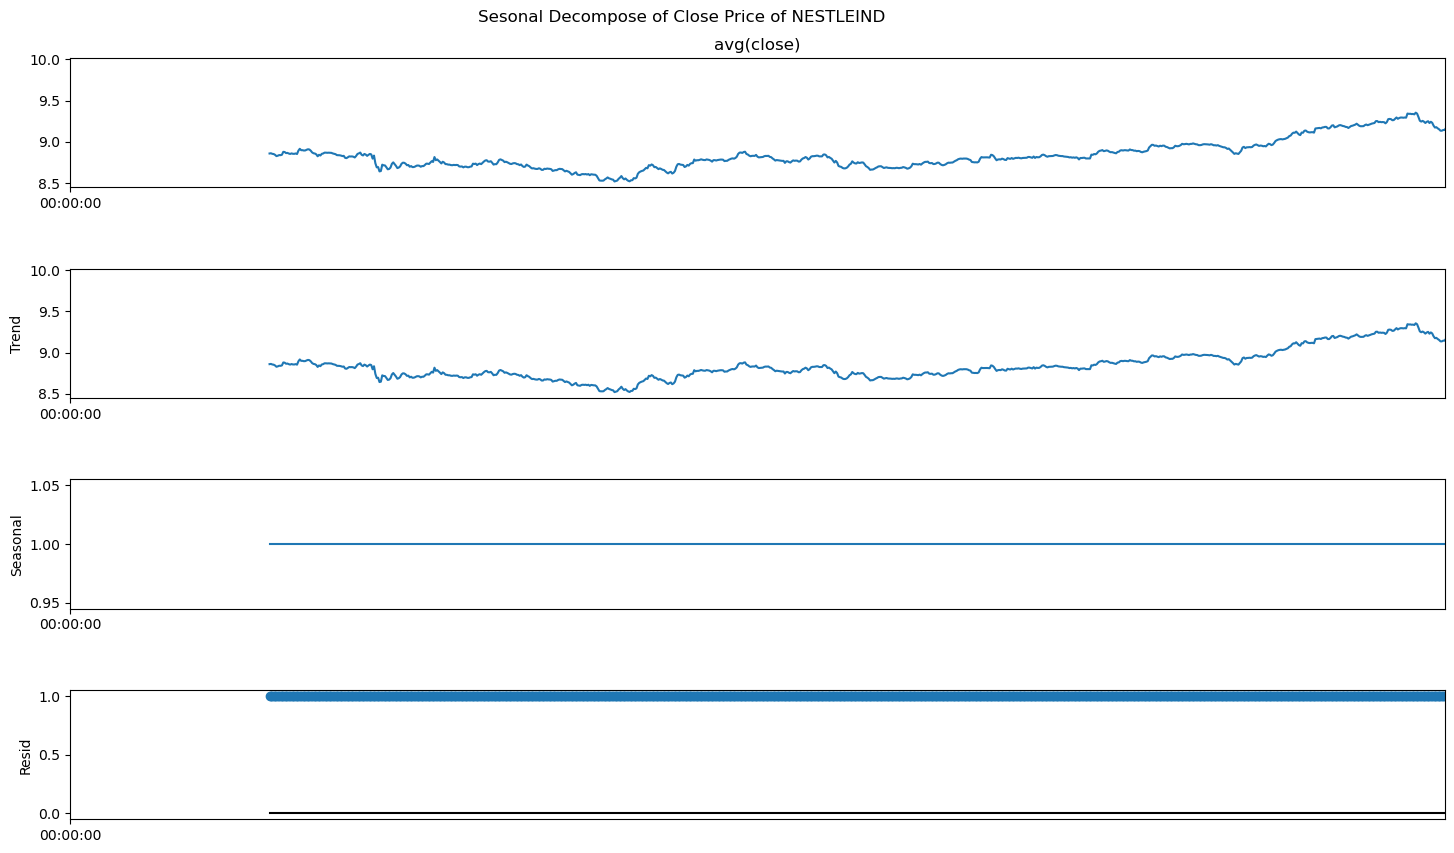

<Figure size 1600x900 with 0 Axes>

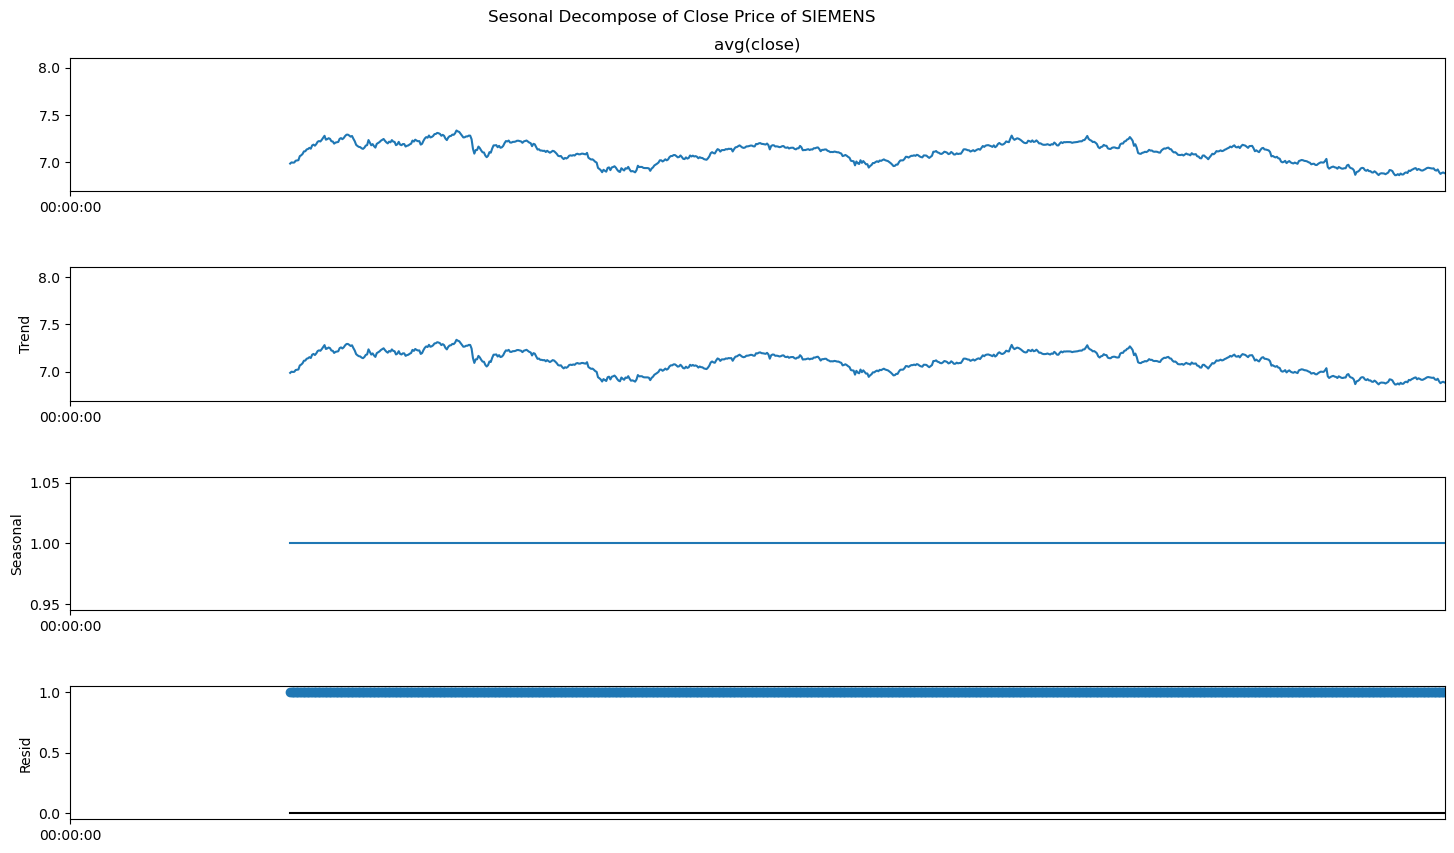

<Figure size 1600x900 with 0 Axes>

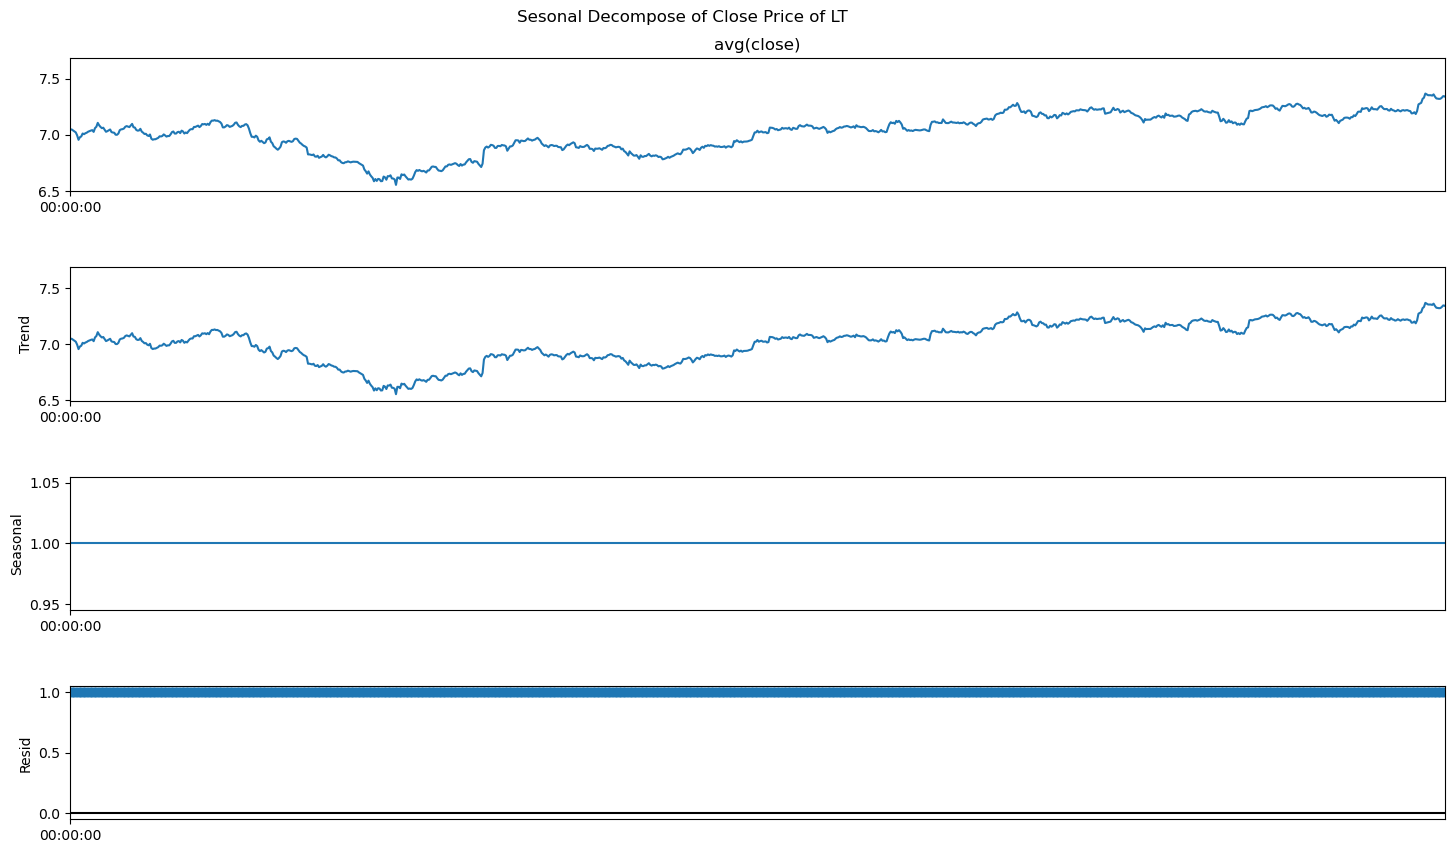

<Figure size 1600x900 with 0 Axes>

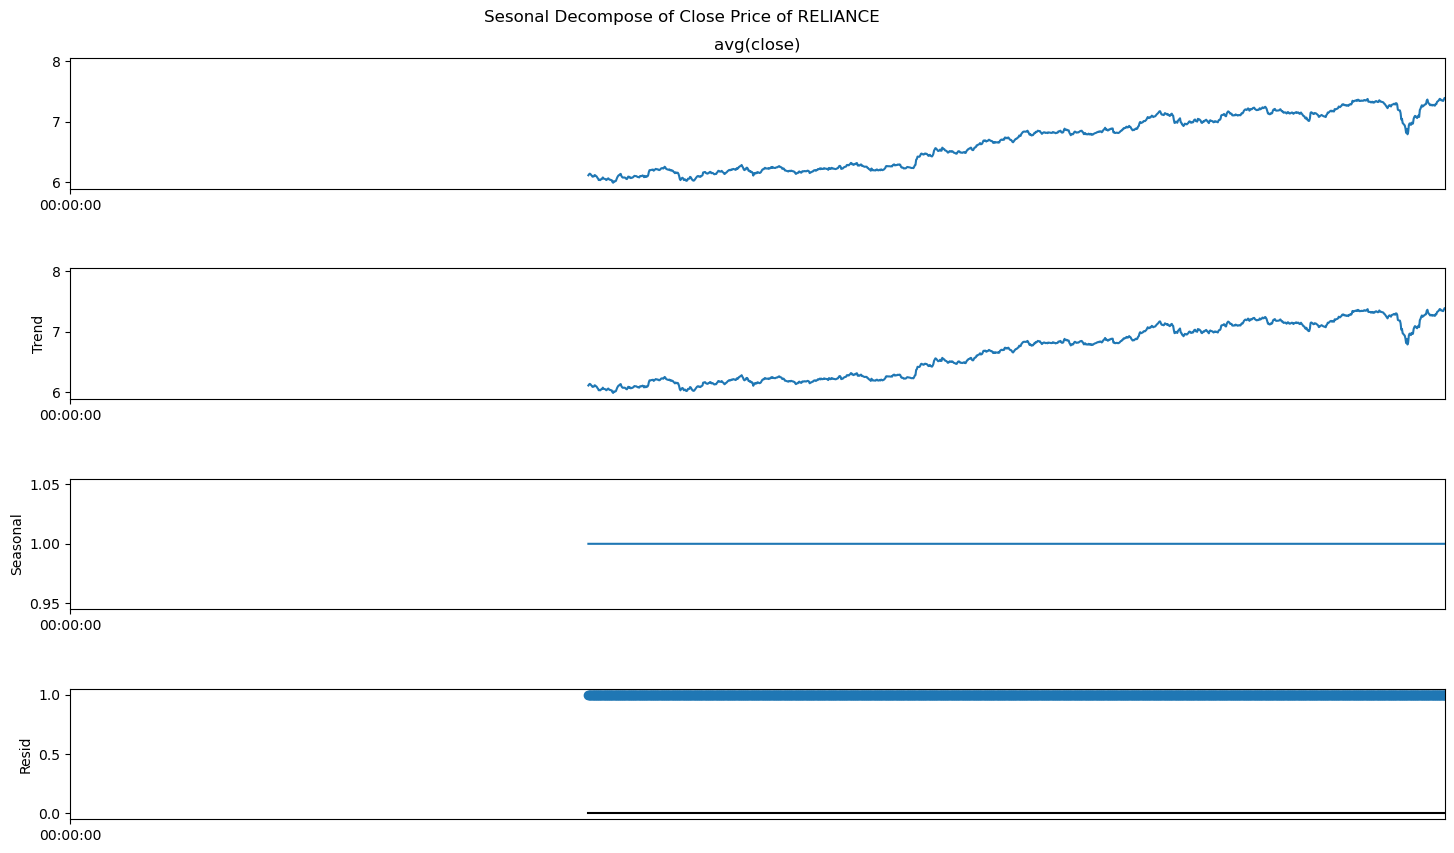

<Figure size 1600x900 with 0 Axes>

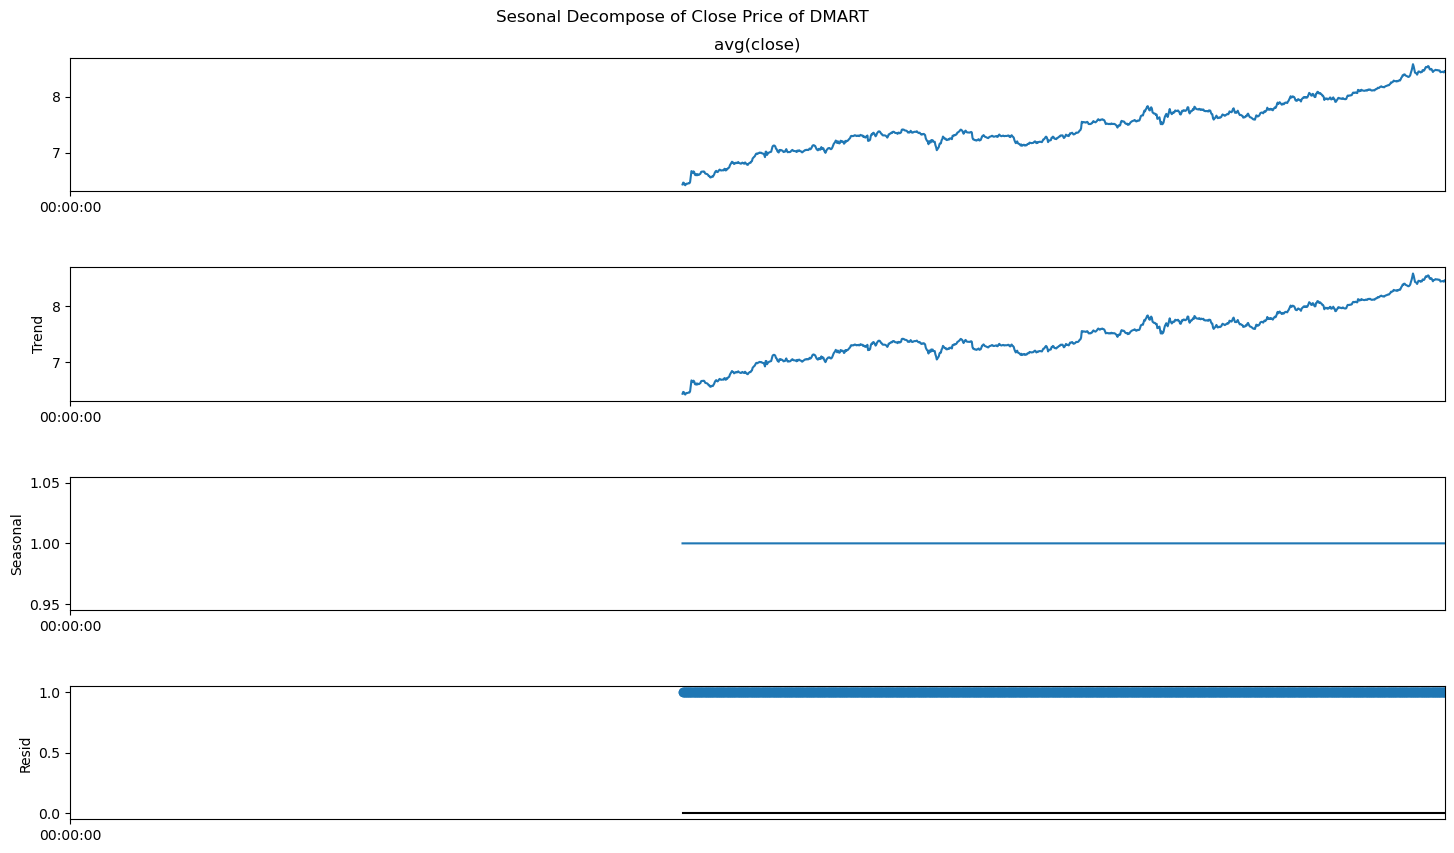

<Figure size 1600x900 with 0 Axes>

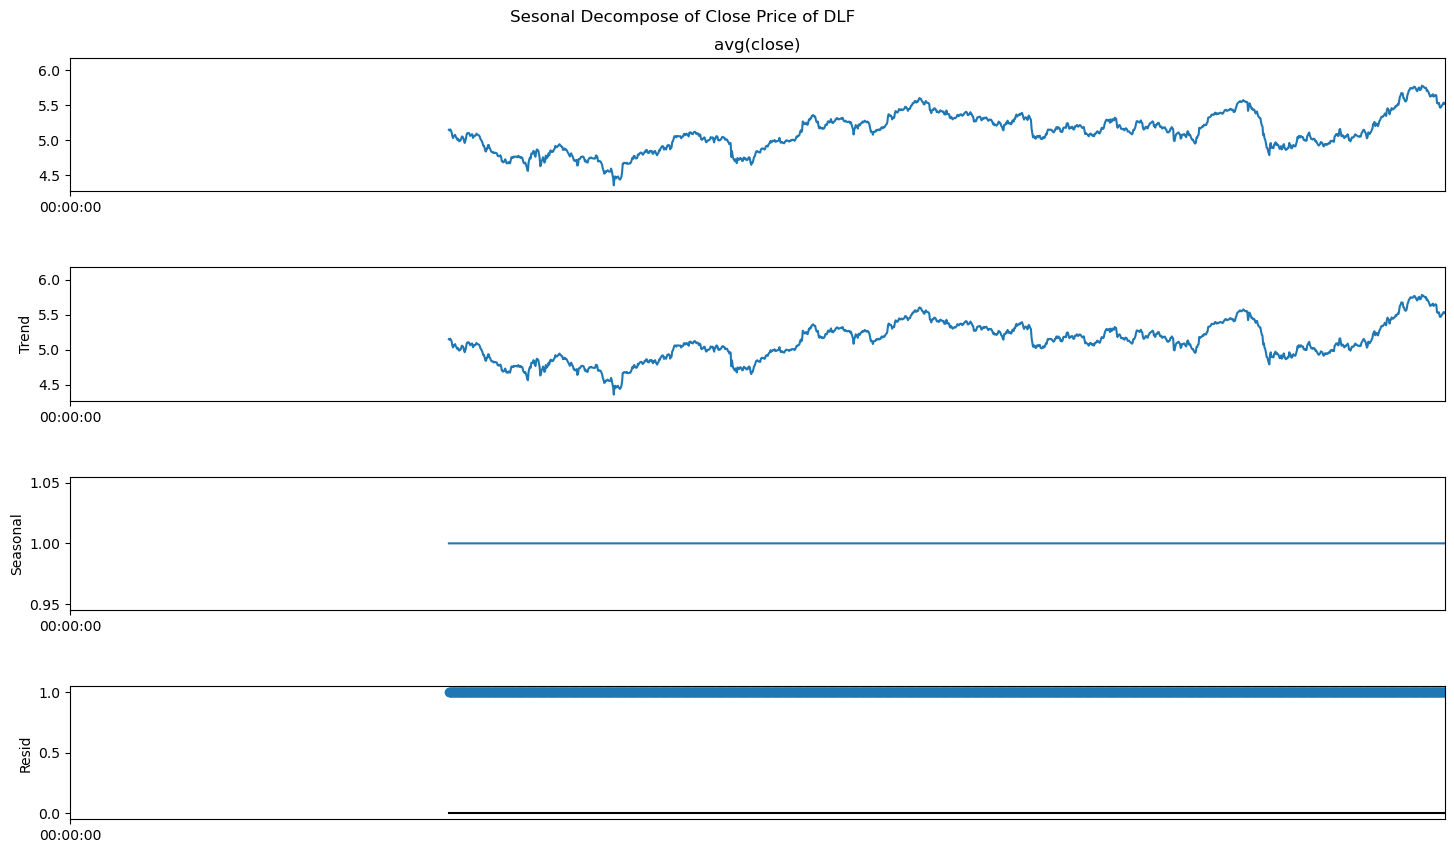

<Figure size 1600x900 with 0 Axes>

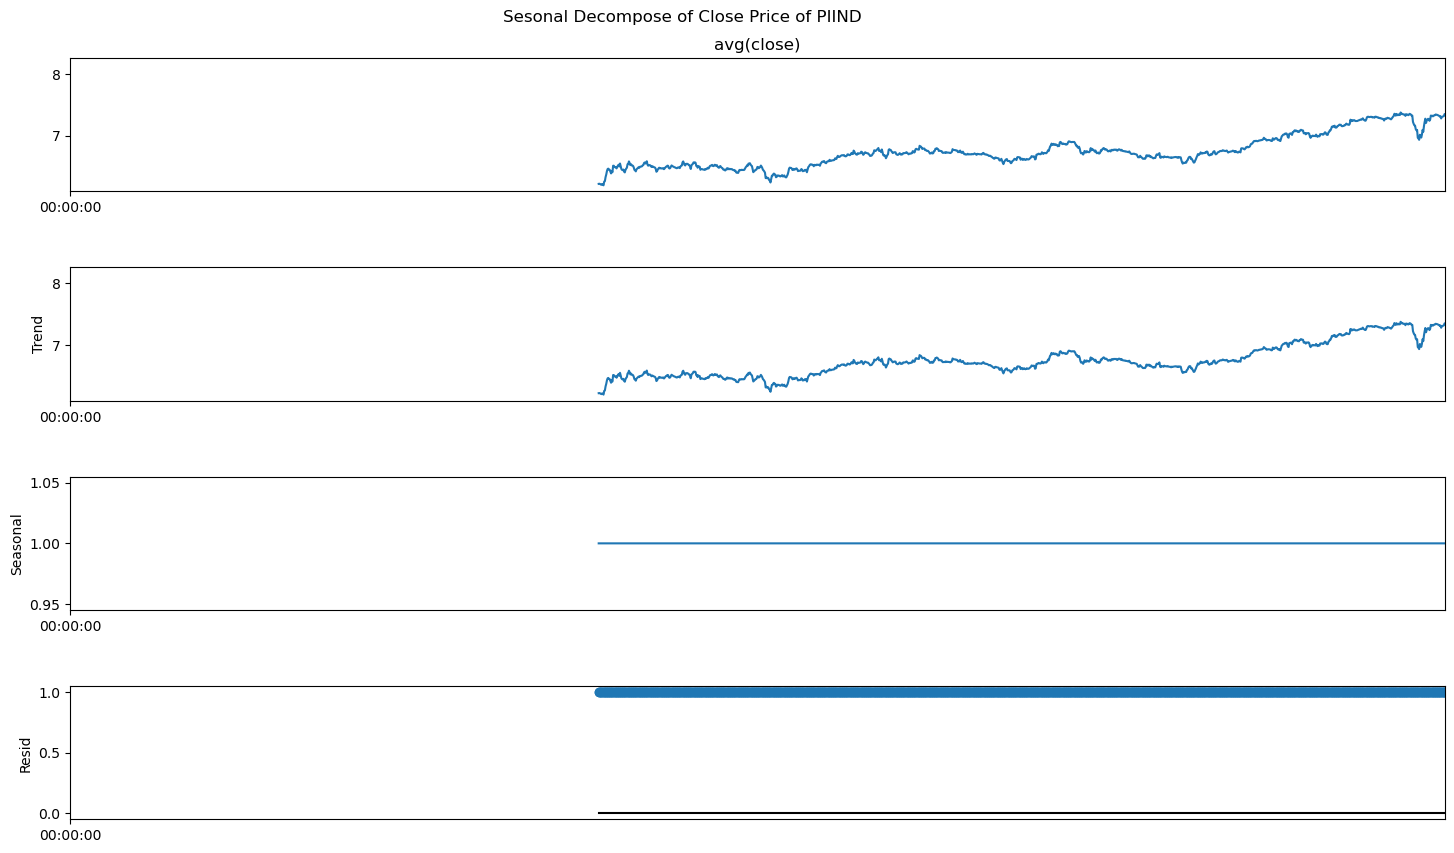

<Figure size 1600x900 with 0 Axes>

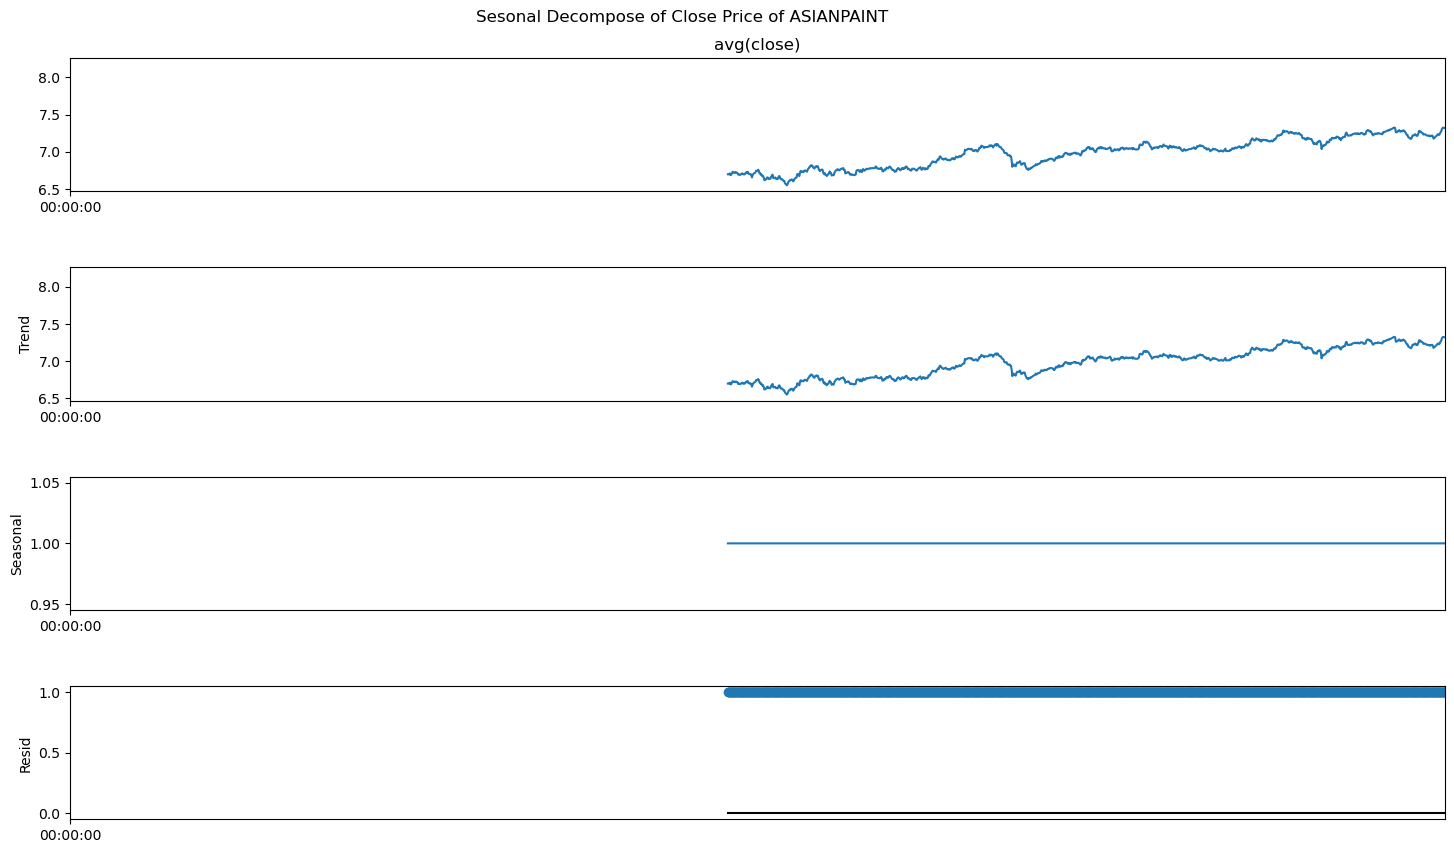

In [ ]:
import numpy as np
for company in top_companies_per_sector:
    company_log = np.log(top_companies_df[top_companies_df['company']==company]['avg(close)'])
    company_log.index = pd.to_datetime(company_log.index)
    result = seasonal_decompose(company_log,  model='multiplicative', period=1)
    fig = plt.figure(figsize=(16, 9))  
    fig = result.plot()  
    fig.set_size_inches(16, 9)
    fig.suptitle('Sesonal Decompose of Close Price of {}'.format(company))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [94]:
top_companies_df.columns

Index(['company', 'day', 'avg(Reverse Repo Rate)', 'avg(RSI14)',
       'avg(Car Registrations)', 'avg(CCI10)', 'avg(TRIMA10)', 'avg(SAR)',
       'avg(fastdsr)', 'avg(ADX20)', 'avg(WILLR)', 'avg(sma10)',
       'avg(macd1226)', 'avg(sma20)', 'avg(ema15)', 'avg(ema10)',
       'avg(KAMA10)', 'avg(TRIMA20)', 'avg(Tourist Arrivals)', 'avg(fastksr)',
       'avg(Steel Production)', 'avg(Gross National Product)', 'avg(TRIMA5)',
       'avg(macd1020)', 'avg(CCI5)', 'avg(MOM15)', 'avg(Export Prices)',
       'avg(TYPPRICE)', 'avg(GDP per Capita PPP)', 'avg(HT_DCPERIOD)',
       'avg(ema5)', 'first(sector)', 'avg(open)', 'avg(Producer Prices)',
       'avg(PPO)', 'avg(ADX10)', 'avg(CCI15)', 'avg(Fiscal Expenditure)',
       'avg(Import Prices)', 'avg(ATR)', 'avg(Crude Oil Production)',
       'avg(upperband)', 'avg(low)', 'avg(BETA)', 'avg(ROC20)', 'avg(macd520)',
       'avg(date)', 'avg(MOM10)', 'avg(fastk)', 'avg(MFI)',
       'avg(Corporate Tax Rate )', 'avg(APO)', 'avg(sma5)', 'avg(KAMA2

ARIMA Summary for INDIGO
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1428
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3309.273
Date:                Wed, 30 Nov 2022   AIC                          -6614.545
Time:                        04:01:58   BIC                          -6604.018
Sample:                             0   HQIC                         -6610.614
                               - 1428                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1973      0.022      9.142      0.000       0.155       0.240
sigma2         0.0006   8.11e-06     69.801      0.000       0.001       0.001
Ljung-Box (L1) (Q):      

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


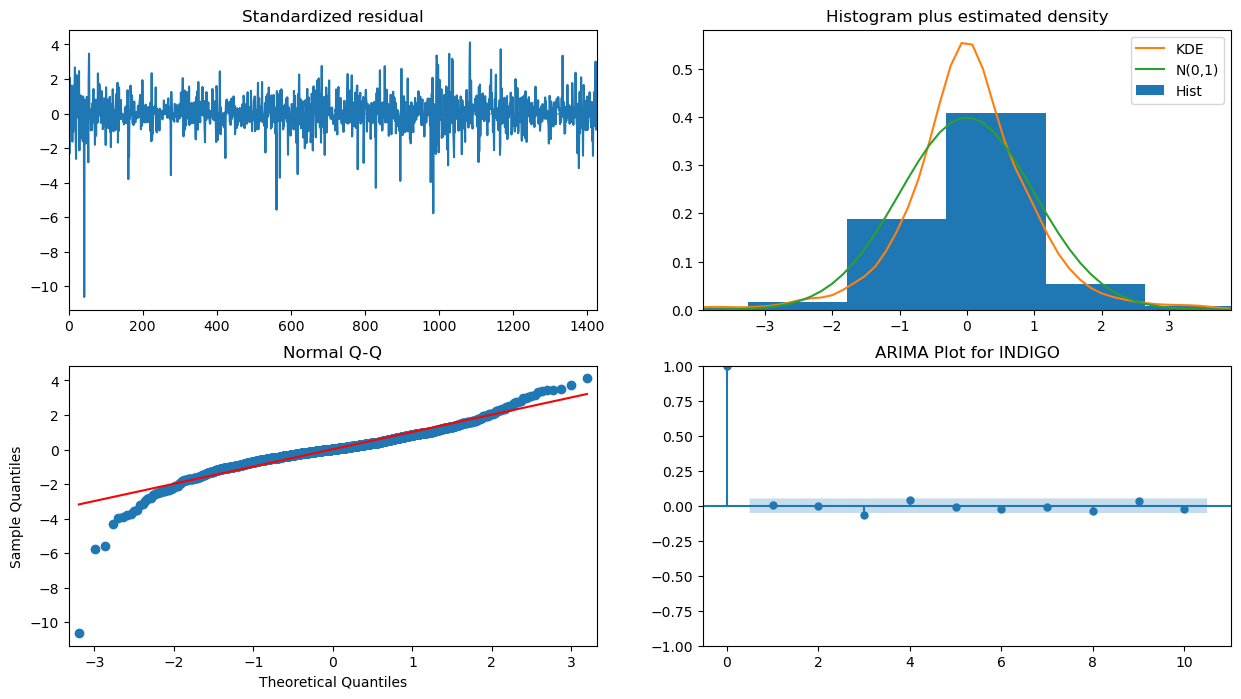

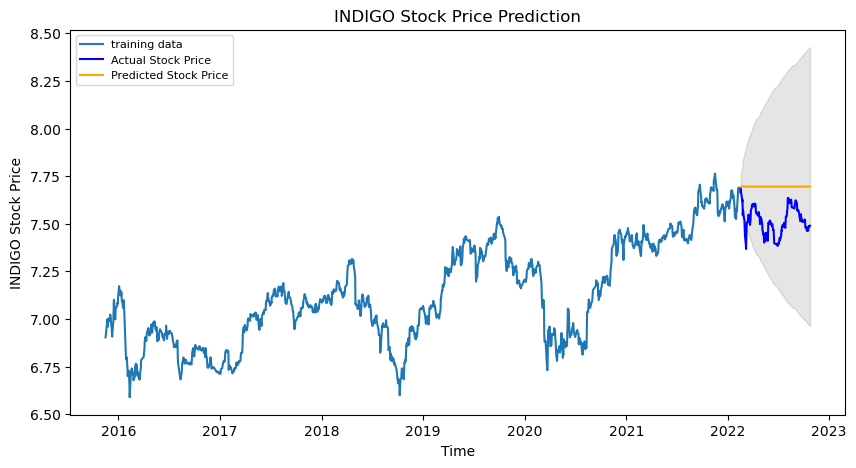

ARIMA Summary for ADANIENT
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1589
Model:               SARIMAX(3, 1, 1)   Log Likelihood                2566.643
Date:                Wed, 30 Nov 2022   AIC                          -5123.286
Time:                        04:02:11   BIC                          -5096.435
Sample:                             0   HQIC                         -5113.312
                               - 1589                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4702      0.274      1.713      0.087      -0.068       1.008
ar.L2         -0.0681      0.058     -1.169      0.242      -0.182       0.046
ar.L3          0.1014  

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


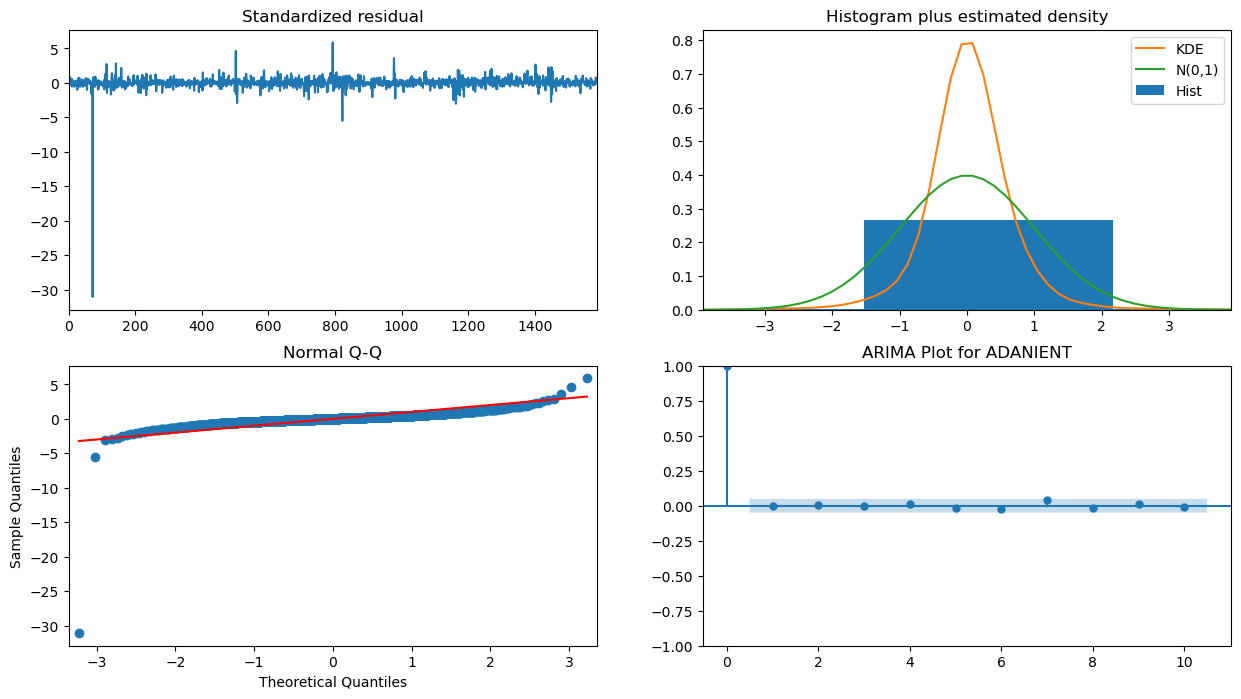

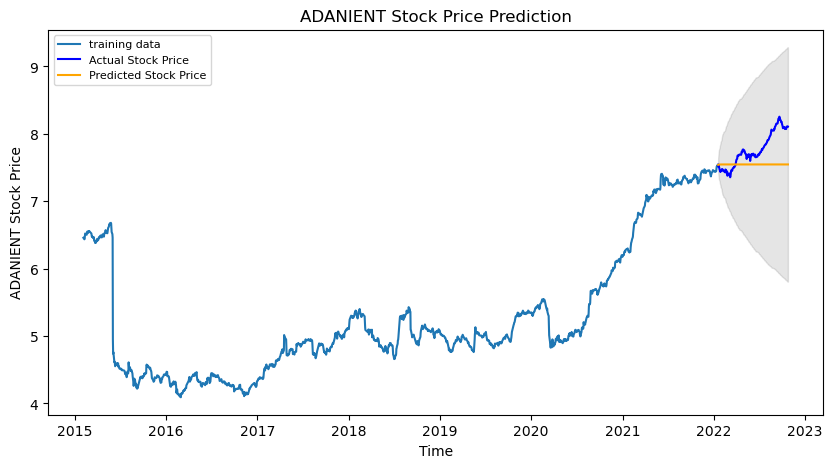

ARIMA Summary for MARUTI
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1614
Model:               SARIMAX(1, 1, 0)   Log Likelihood                4379.565
Date:                Wed, 30 Nov 2022   AIC                          -8755.130
Time:                        04:02:15   BIC                          -8744.359
Sample:                             0   HQIC                         -8751.132
                               - 1614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1824      0.016     11.348      0.000       0.151       0.214
sigma2         0.0003   4.03e-06     63.655      0.000       0.000       0.000
Ljung-Box (L1) (Q):      

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


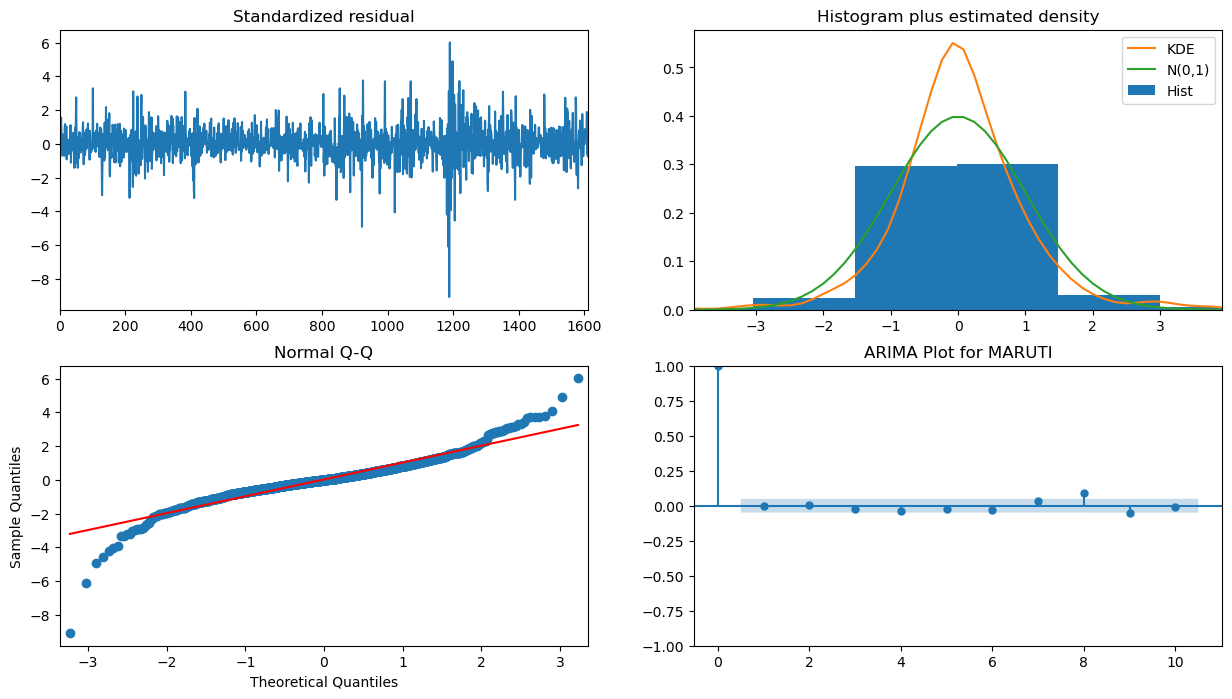

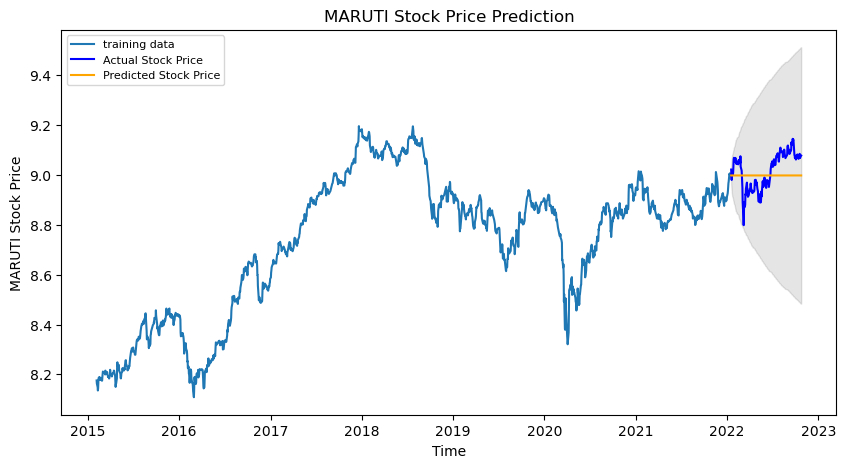

ARIMA Summary for BHARTIARTL
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1614
Model:               SARIMAX(0, 1, 1)   Log Likelihood                4191.650
Date:                Wed, 30 Nov 2022   AIC                          -8379.301
Time:                        04:02:20   BIC                          -8368.529
Sample:                             0   HQIC                         -8375.303
                               - 1614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1206      0.021      5.632      0.000       0.079       0.163
sigma2         0.0003   7.88e-06     41.053      0.000       0.000       0.000
Ljung-Box (L1) (Q):  

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


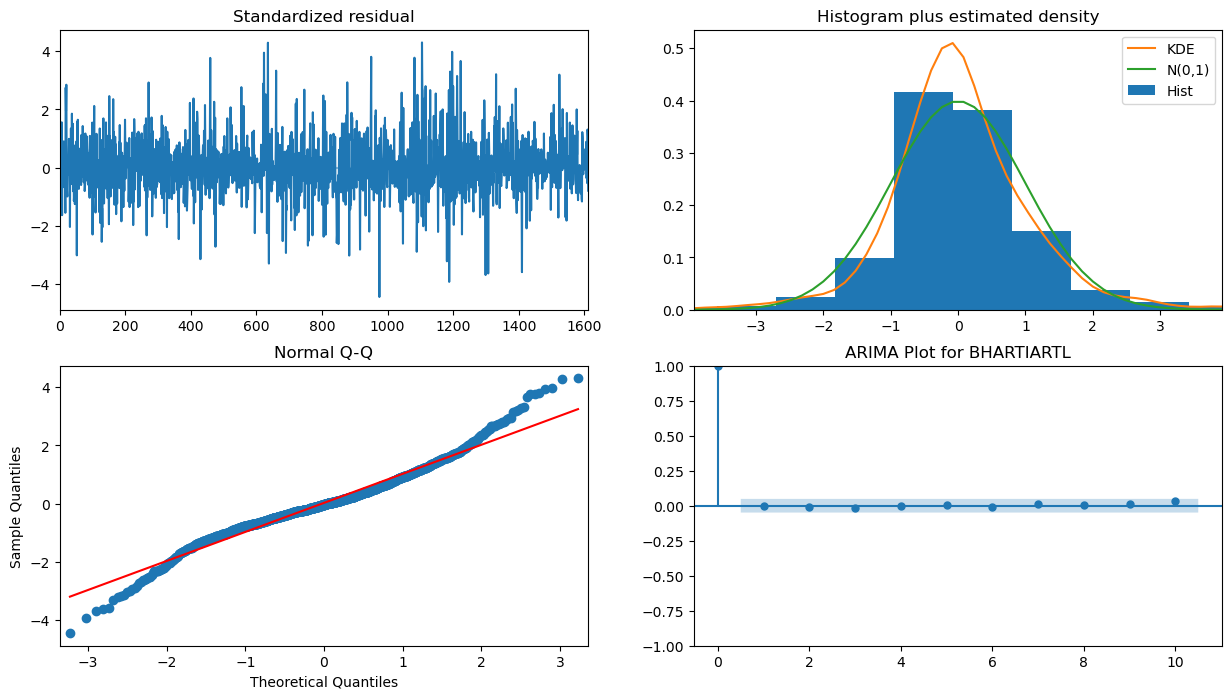

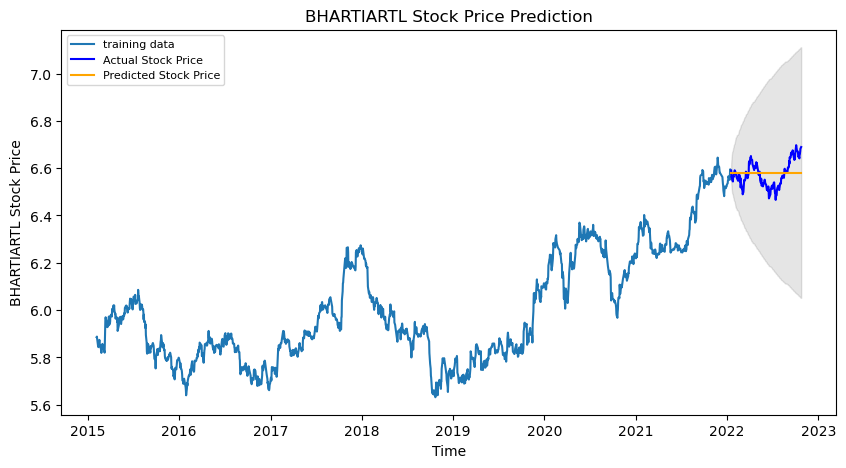

ARIMA Summary for BAJFINANCE
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1614
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3830.036
Date:                Wed, 30 Nov 2022   AIC                          -7654.072
Time:                        04:02:24   BIC                          -7637.914
Sample:                             0   HQIC                         -7648.075
                               - 1614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.001      2.786      0.005       0.001       0.003
ma.L1          0.1538      0.015      9.931      0.000       0.123       0.184
sigma2         0.0005

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


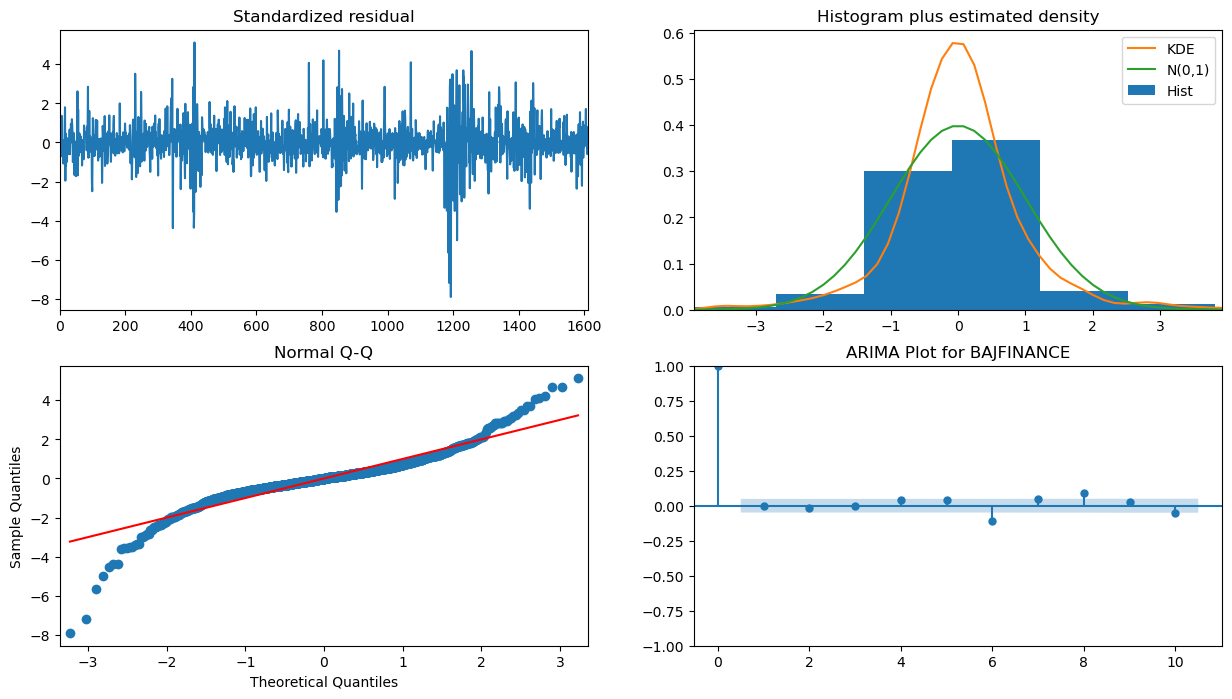

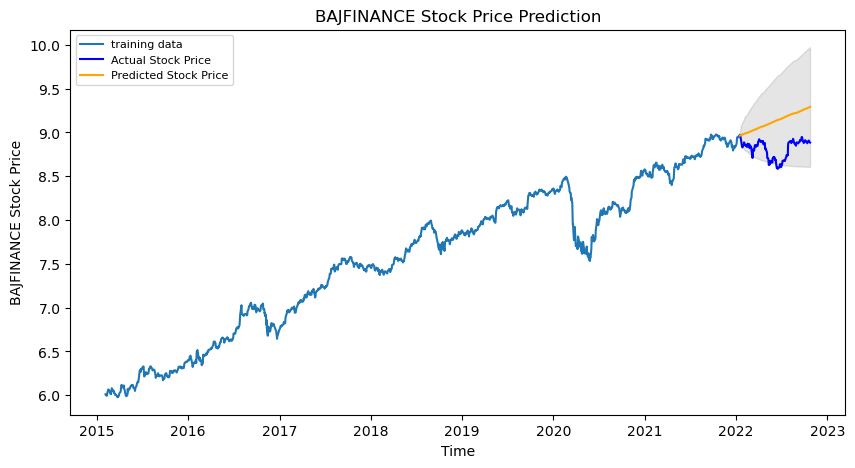

ARIMA Summary for APOLLOHOSP
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1614
Model:               SARIMAX(0, 1, 1)   Log Likelihood                4055.343
Date:                Wed, 30 Nov 2022   AIC                          -8106.685
Time:                        04:02:26   BIC                          -8095.914
Sample:                             0   HQIC                         -8102.687
                               - 1614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1810      0.016     11.542      0.000       0.150       0.212
sigma2         0.0004   7.02e-06     54.579      0.000       0.000       0.000
Ljung-Box (L1) (Q):  

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


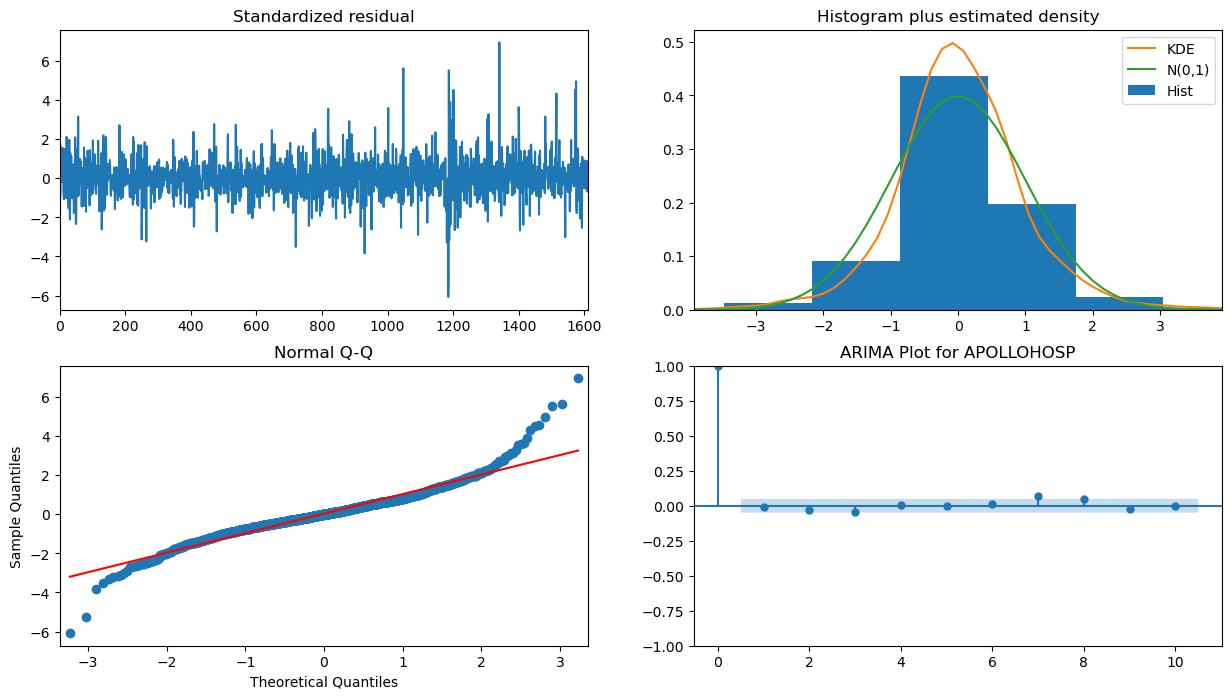

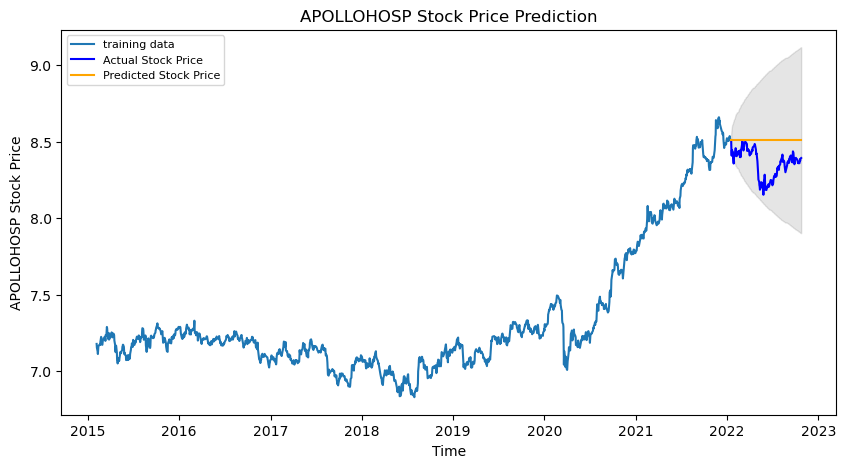

ARIMA Summary for ADANIGREEN
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  893
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1624.968
Date:                Wed, 30 Nov 2022   AIC                          -3243.936
Time:                        04:02:30   BIC                          -3229.556
Sample:                             0   HQIC                         -3238.440
                                - 893                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0049      0.002      2.675      0.007       0.001       0.008
ma.L1          0.2066      0.027      7.621      0.000       0.153       0.260
sigma2         0.0015

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


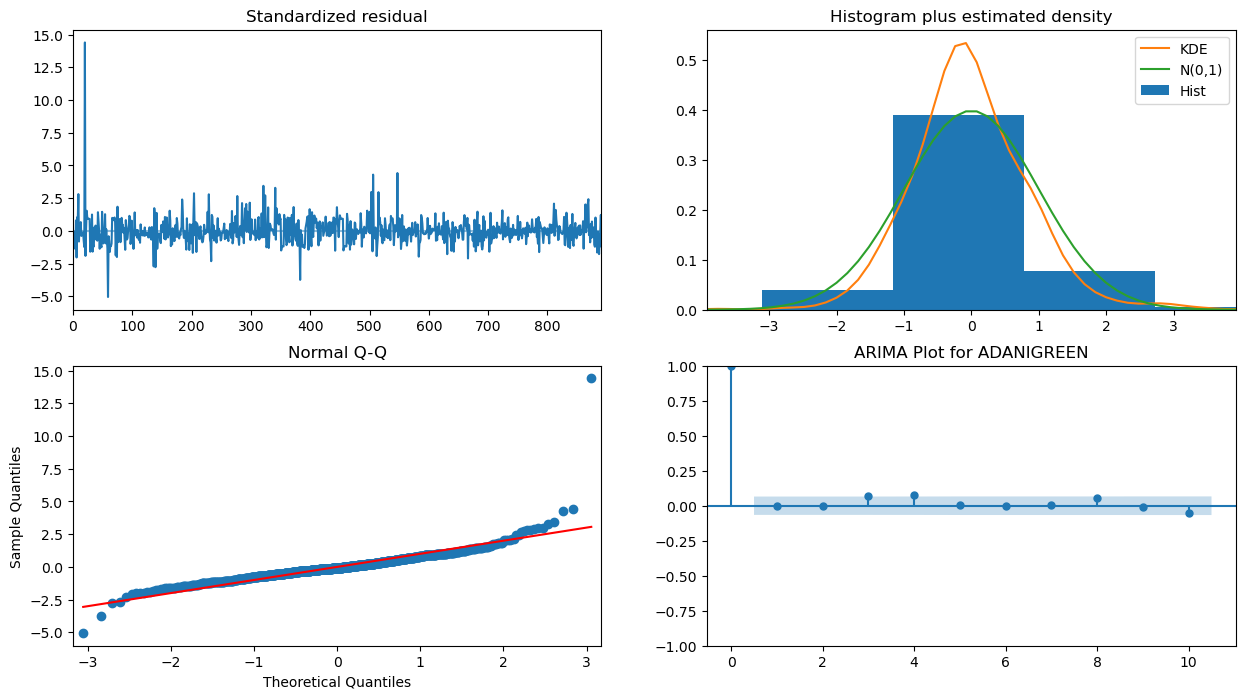

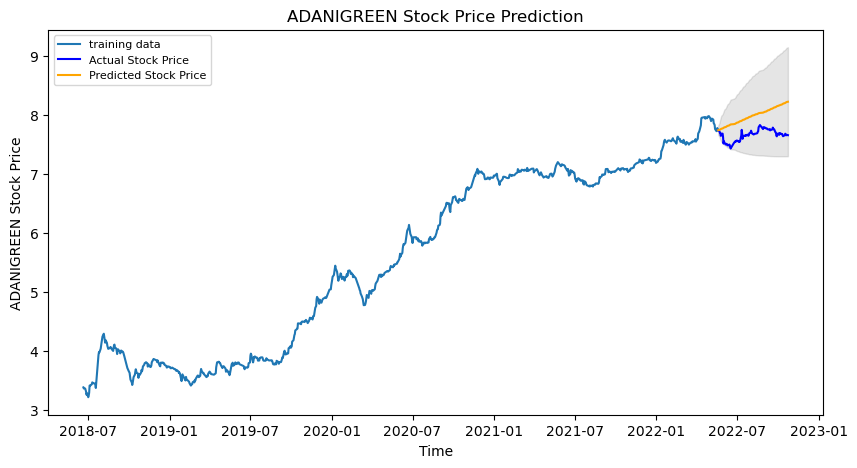

ARIMA Summary for LTI
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1308
Model:               SARIMAX(3, 1, 0)   Log Likelihood                3249.926
Date:                Wed, 30 Nov 2022   AIC                          -6489.852
Time:                        04:02:34   BIC                          -6463.975
Sample:                             0   HQIC                         -6480.145
                               - 1308                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.001      2.706      0.007       0.000       0.003
ar.L1          0.0916      0.017      5.520      0.000       0.059       0.124
ar.L2          0.0513      0

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


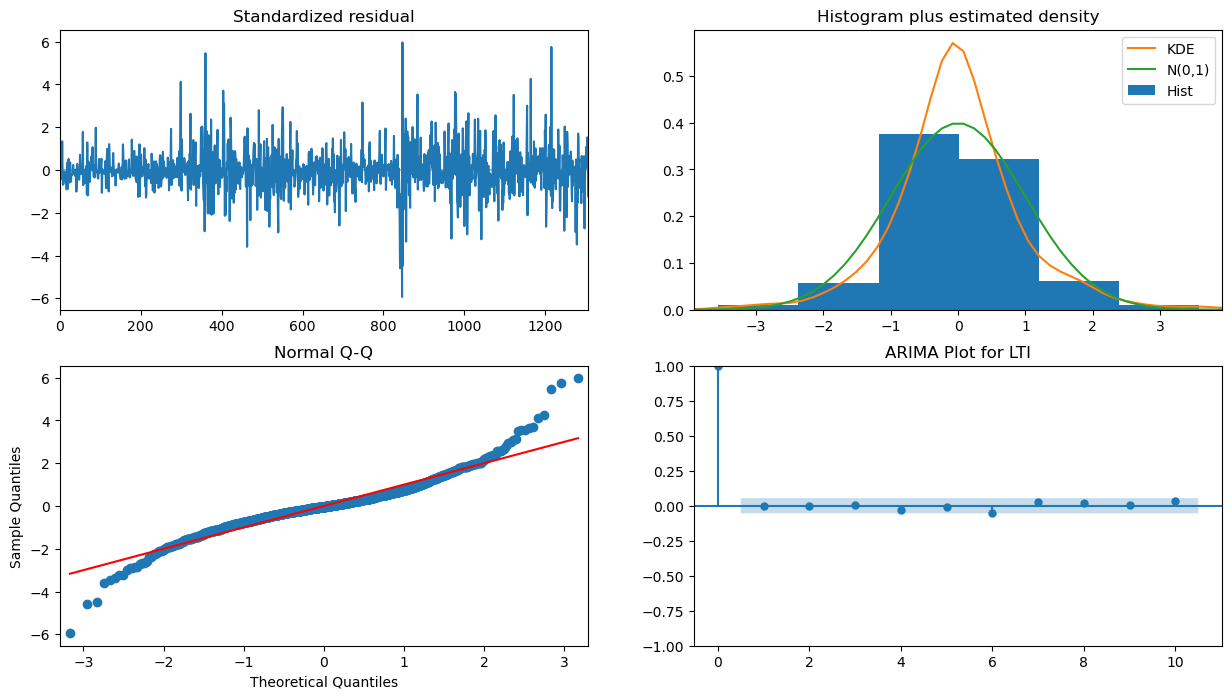

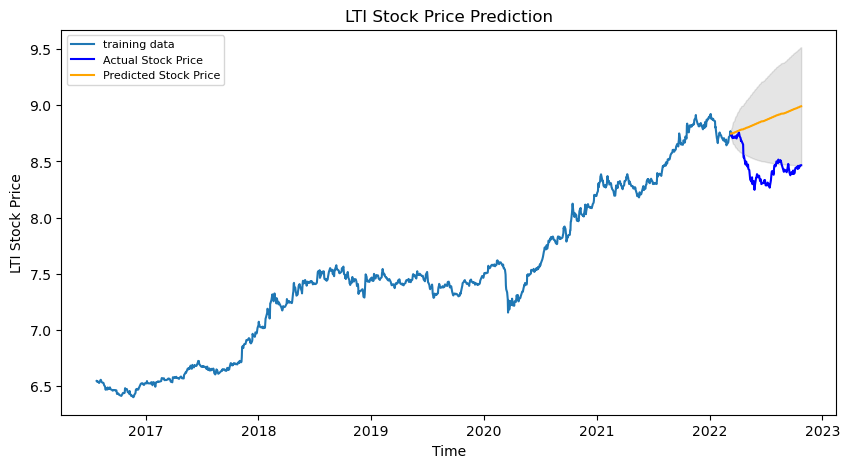

ARIMA Summary for SHREECEM
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1614
Model:               SARIMAX(1, 0, 2)   Log Likelihood                4252.718
Date:                Wed, 30 Nov 2022   AIC                          -8495.437
Time:                        04:02:55   BIC                          -8468.505
Sample:                             0   HQIC                         -8485.440
                               - 1614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0230      0.017      1.327      0.184      -0.011       0.057
ar.L1          0.9976      0.002    557.474      0.000       0.994       1.001
ma.L1          0.1545  

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


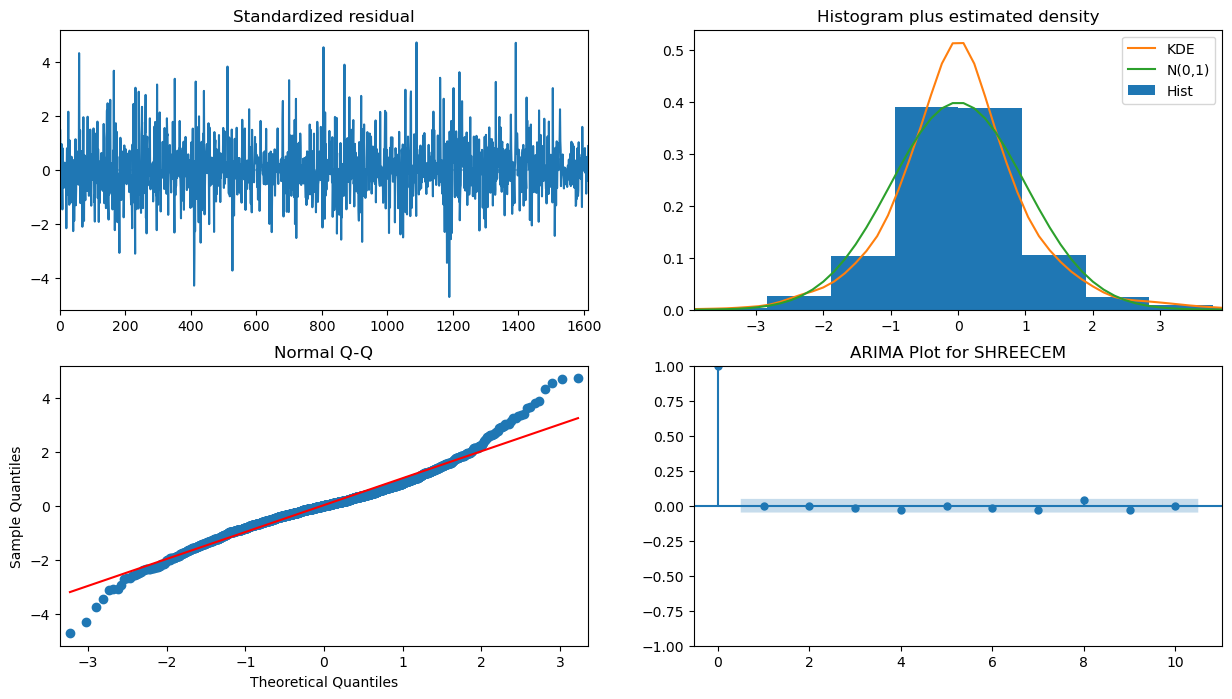

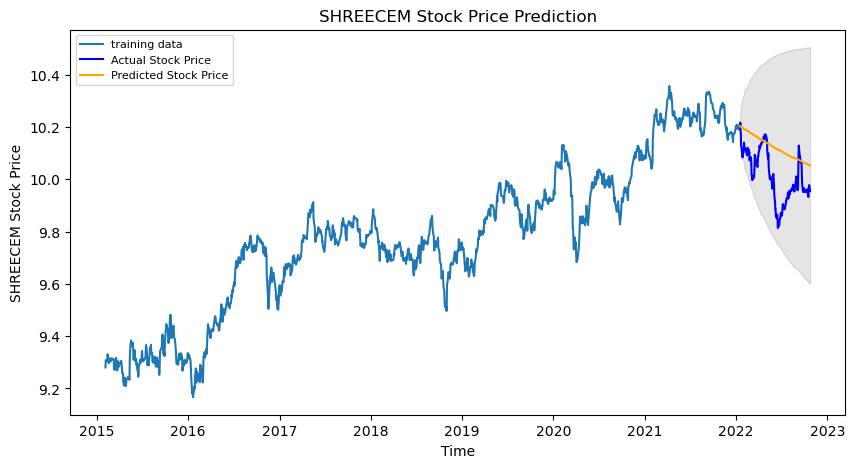

ARIMA Summary for NESTLEIND
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1614
Model:               SARIMAX(0, 1, 1)   Log Likelihood                4668.159
Date:                Wed, 30 Nov 2022   AIC                          -9330.318
Time:                        04:02:59   BIC                          -9314.161
Sample:                             0   HQIC                         -9324.321
                               - 1614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.000      1.673      0.094      -0.000       0.001
ma.L1          0.1190      0.014      8.497      0.000       0.092       0.146
sigma2         0.0002 

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


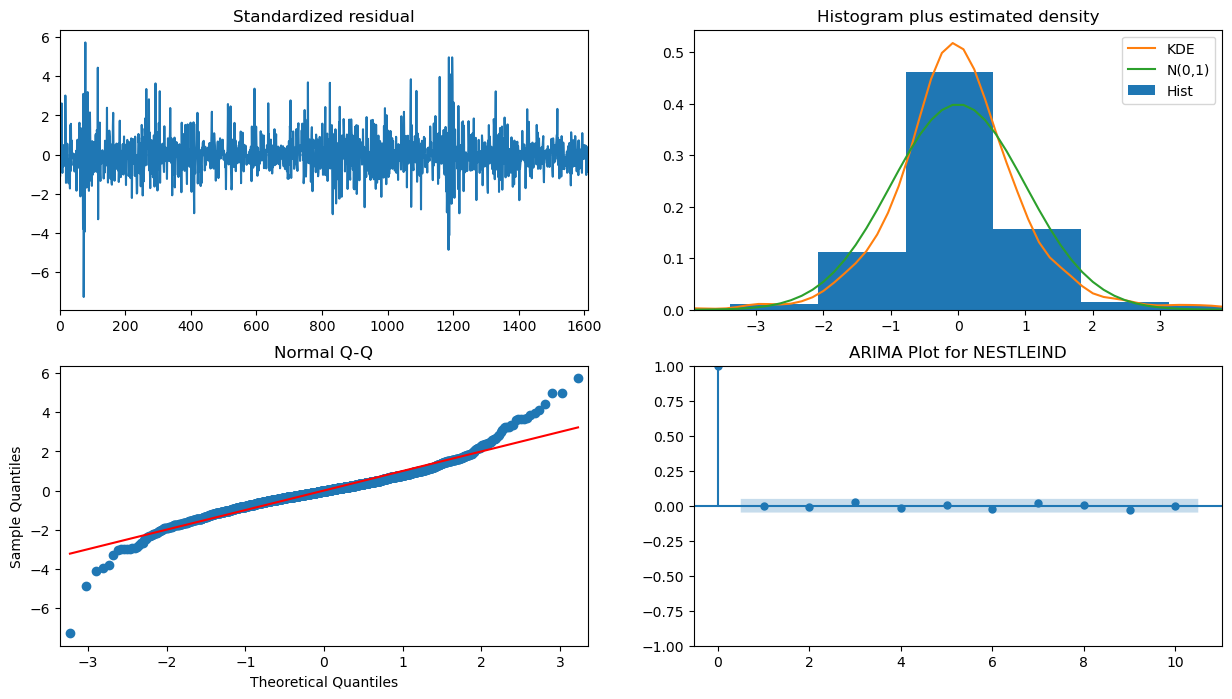

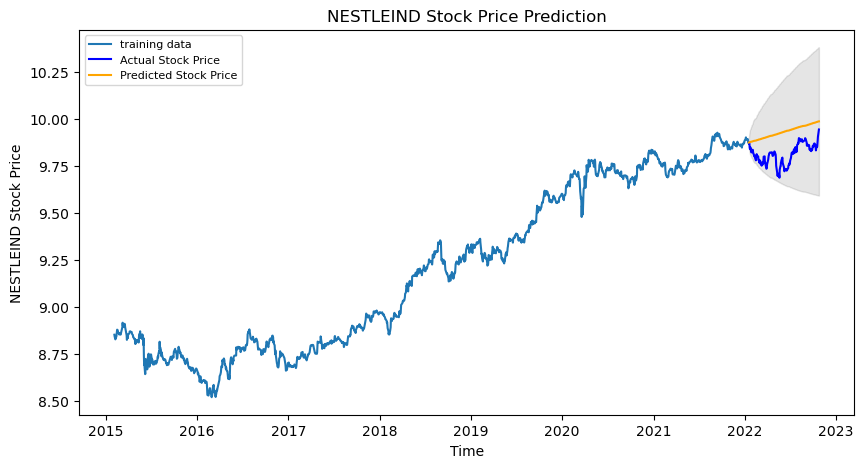

ARIMA Summary for SIEMENS
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1614
Model:               SARIMAX(1, 1, 0)   Log Likelihood                4300.283
Date:                Wed, 30 Nov 2022   AIC                          -8596.566
Time:                        04:03:03   BIC                          -8585.794
Sample:                             0   HQIC                         -8592.568
                               - 1614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1026      0.020      5.089      0.000       0.063       0.142
sigma2         0.0003   5.63e-06     50.286      0.000       0.000       0.000
Ljung-Box (L1) (Q):     

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


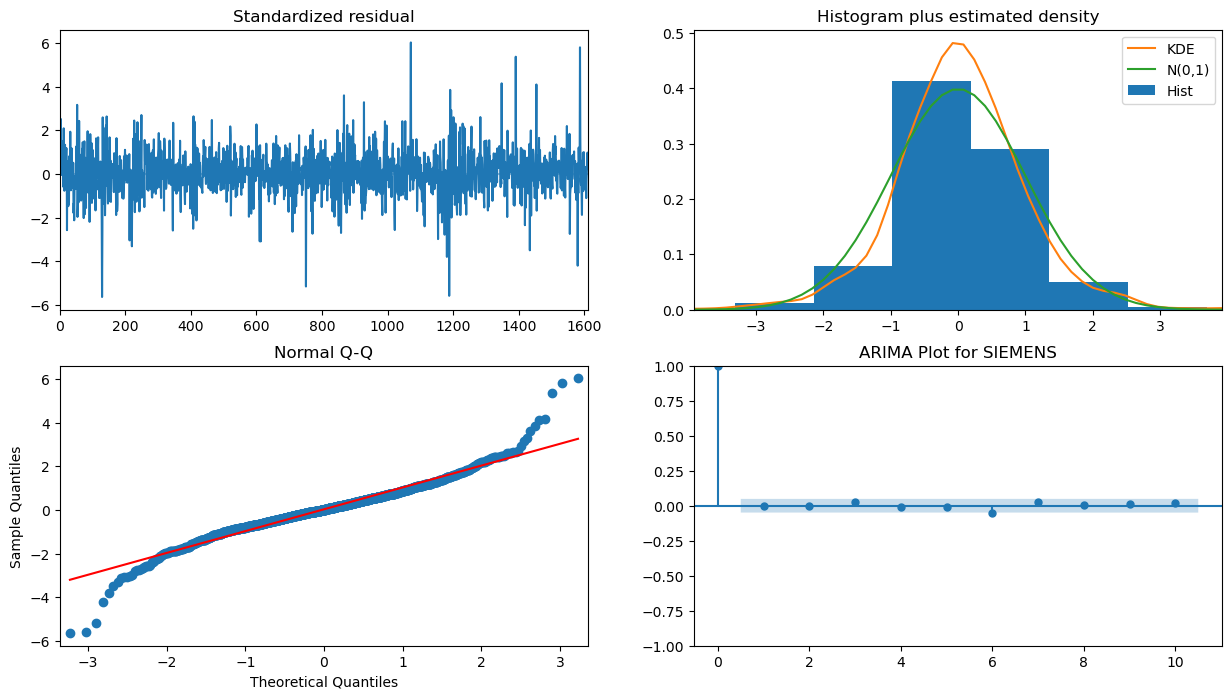

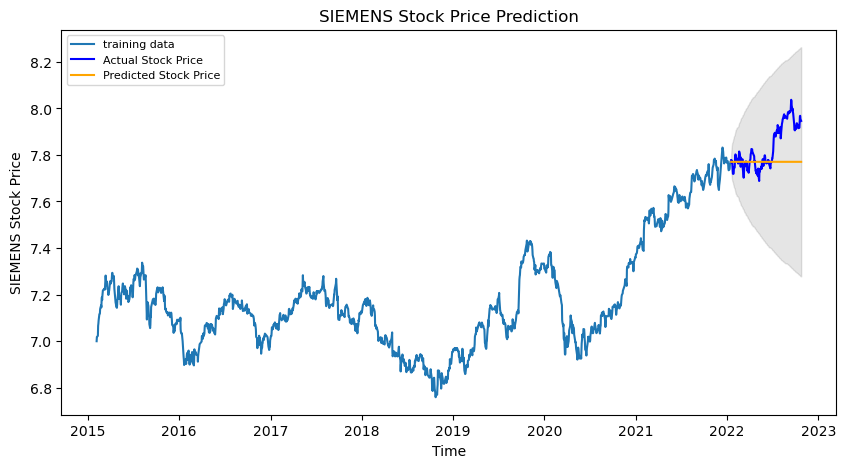

ARIMA Summary for LT
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1589
Model:               SARIMAX(1, 1, 0)   Log Likelihood                4295.035
Date:                Wed, 30 Nov 2022   AIC                          -8586.069
Time:                        04:03:07   BIC                          -8575.329
Sample:                             0   HQIC                         -8582.079
                               - 1589                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1707      0.018      9.459      0.000       0.135       0.206
sigma2         0.0003   3.75e-06     69.818      0.000       0.000       0.000
Ljung-Box (L1) (Q):          

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


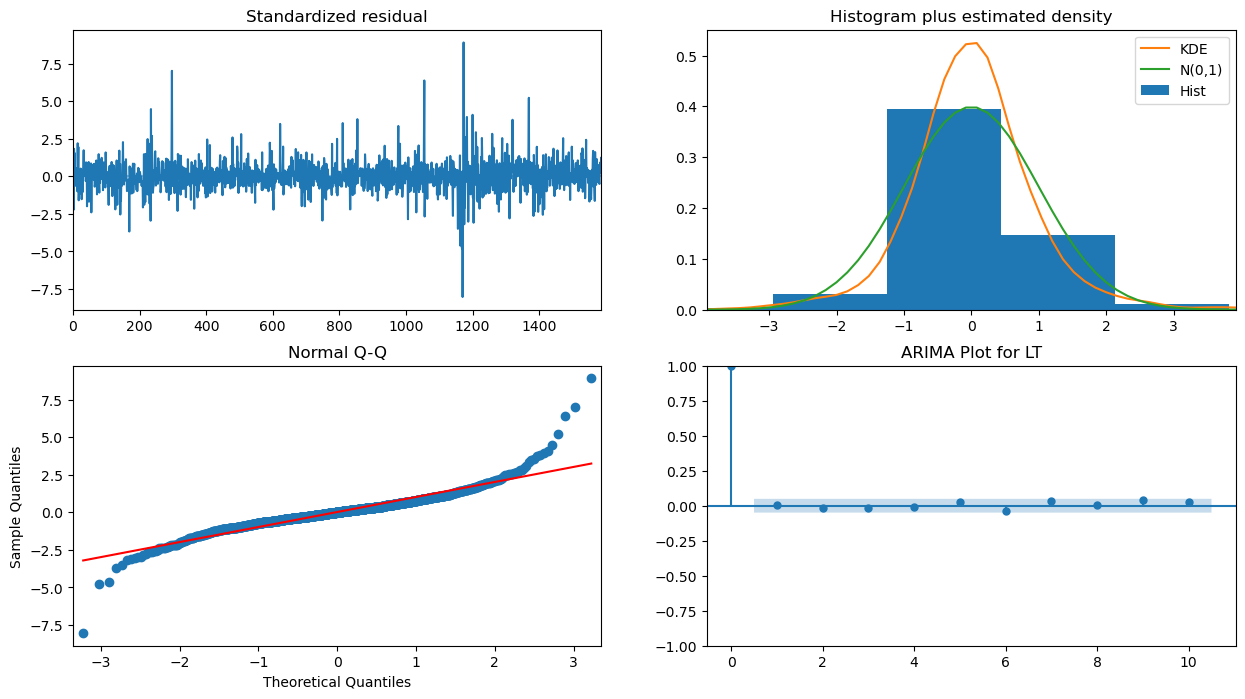

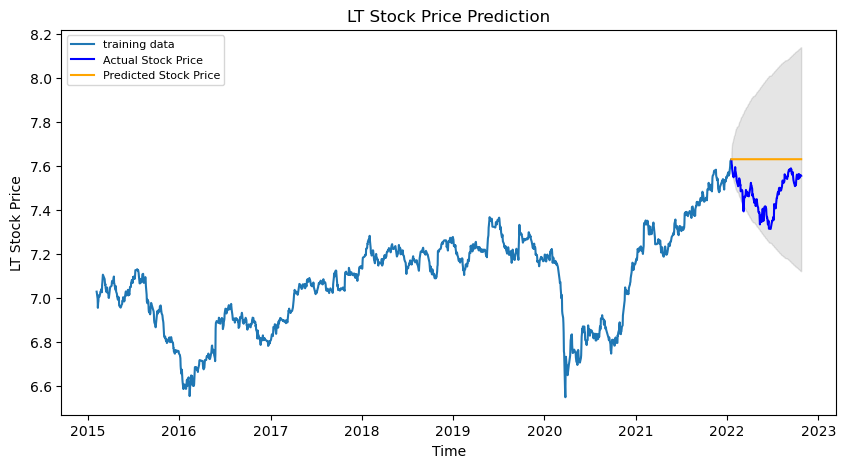

ARIMA Summary for RELIANCE
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1614
Model:               SARIMAX(2, 0, 1)   Log Likelihood                4358.280
Date:                Wed, 30 Nov 2022   AIC                          -8706.559
Time:                        04:03:28   BIC                          -8679.627
Sample:                             0   HQIC                         -8696.563
                               - 1614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.005      0.459      0.646      -0.007       0.011
ar.L1          1.2902      0.085     15.102      0.000       1.123       1.458
ar.L2         -0.2905  

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


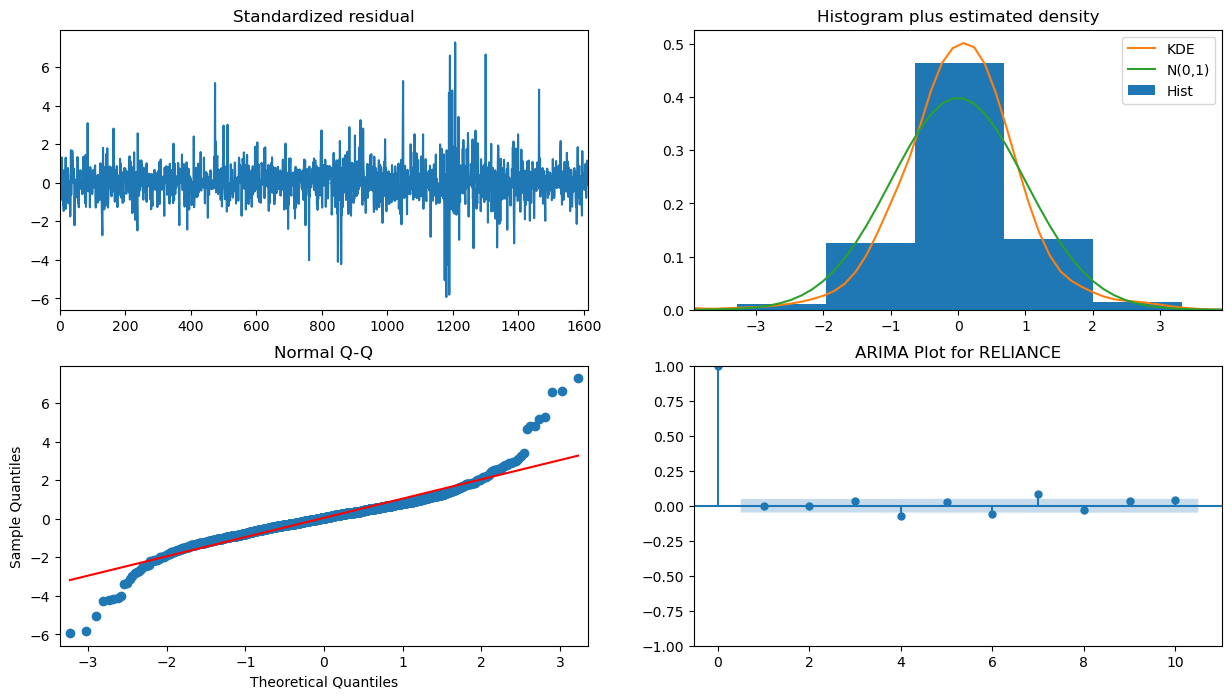

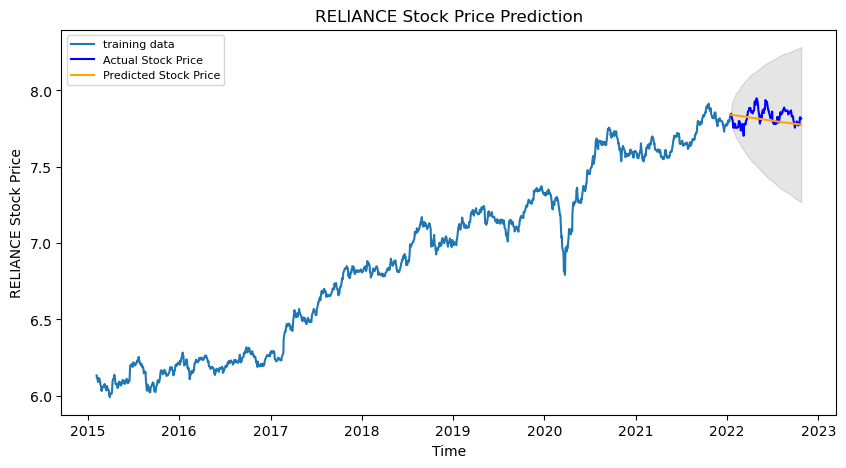

ARIMA Summary for DMART
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1169
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2938.184
Date:                Wed, 30 Nov 2022   AIC                          -5870.369
Time:                        04:03:31   BIC                          -5855.180
Sample:                             0   HQIC                         -5864.640
                               - 1169                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.001      2.288      0.022       0.000       0.003
ma.L1          0.2157      0.021     10.285      0.000       0.175       0.257
sigma2         0.0004   9.

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


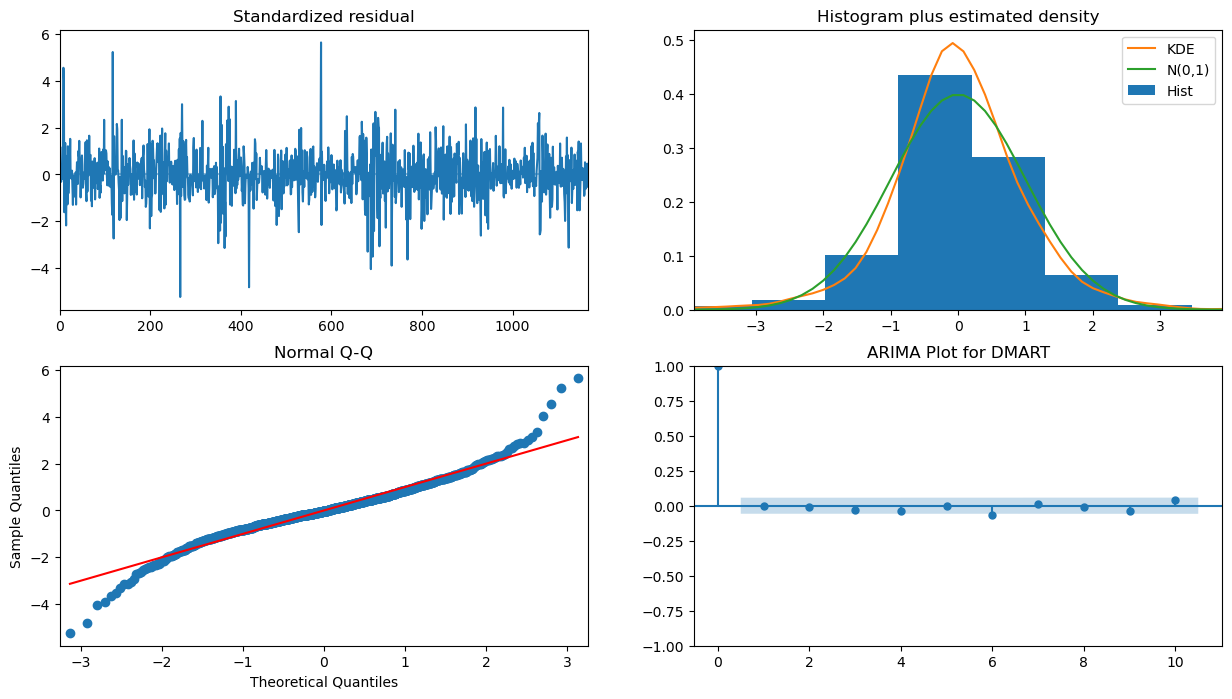

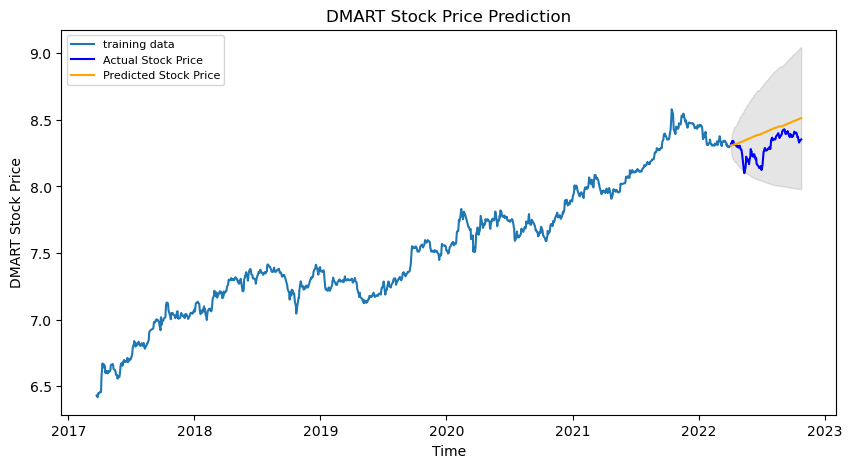

ARIMA Summary for DLF
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1614
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3576.942
Date:                Wed, 30 Nov 2022   AIC                          -7149.883
Time:                        04:03:34   BIC                          -7139.112
Sample:                             0   HQIC                         -7145.885
                               - 1614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1161      0.018      6.554      0.000       0.081       0.151
sigma2         0.0007   1.24e-05     56.064      0.000       0.001       0.001
Ljung-Box (L1) (Q):         

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


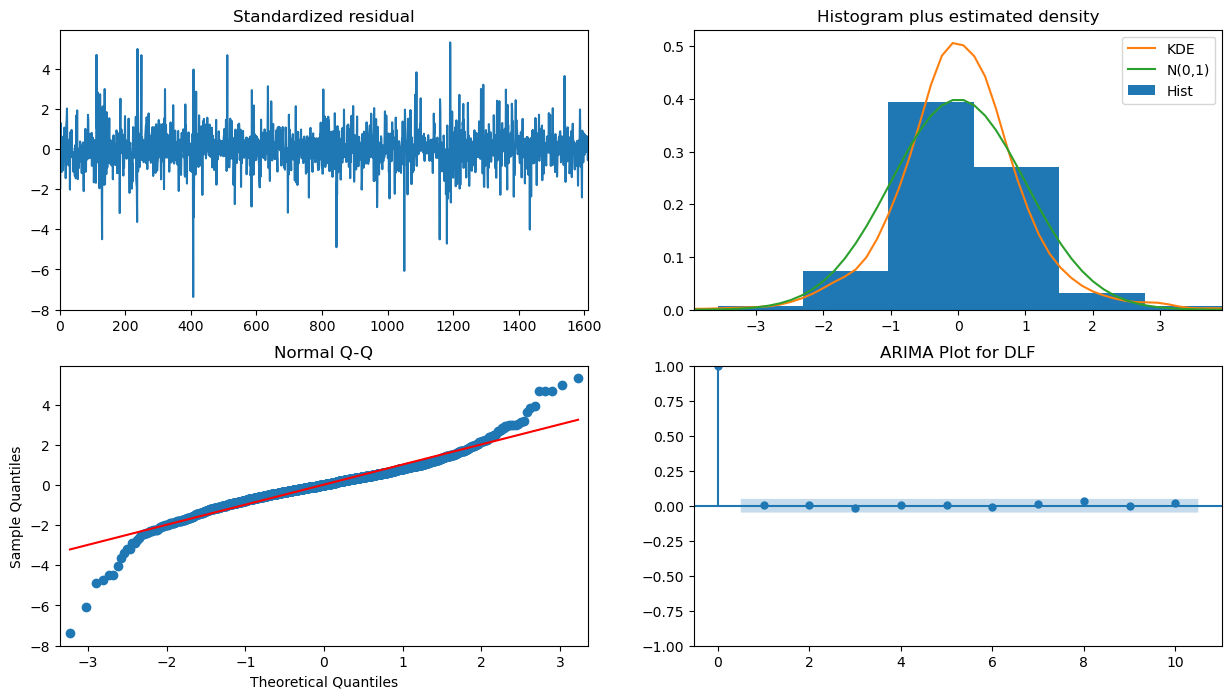

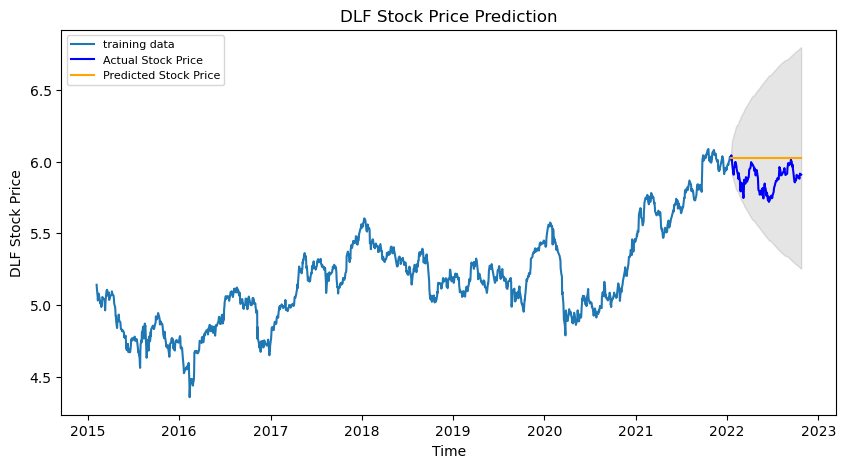

ARIMA Summary for PIIND
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1614
Model:               SARIMAX(0, 1, 1)   Log Likelihood                4094.138
Date:                Wed, 30 Nov 2022   AIC                          -8182.275
Time:                        04:03:39   BIC                          -8166.118
Sample:                             0   HQIC                         -8176.278
                               - 1614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.001      2.060      0.039     5.2e-05       0.002
ma.L1          0.0832      0.019      4.271      0.000       0.045       0.121
sigma2         0.0004   6.

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


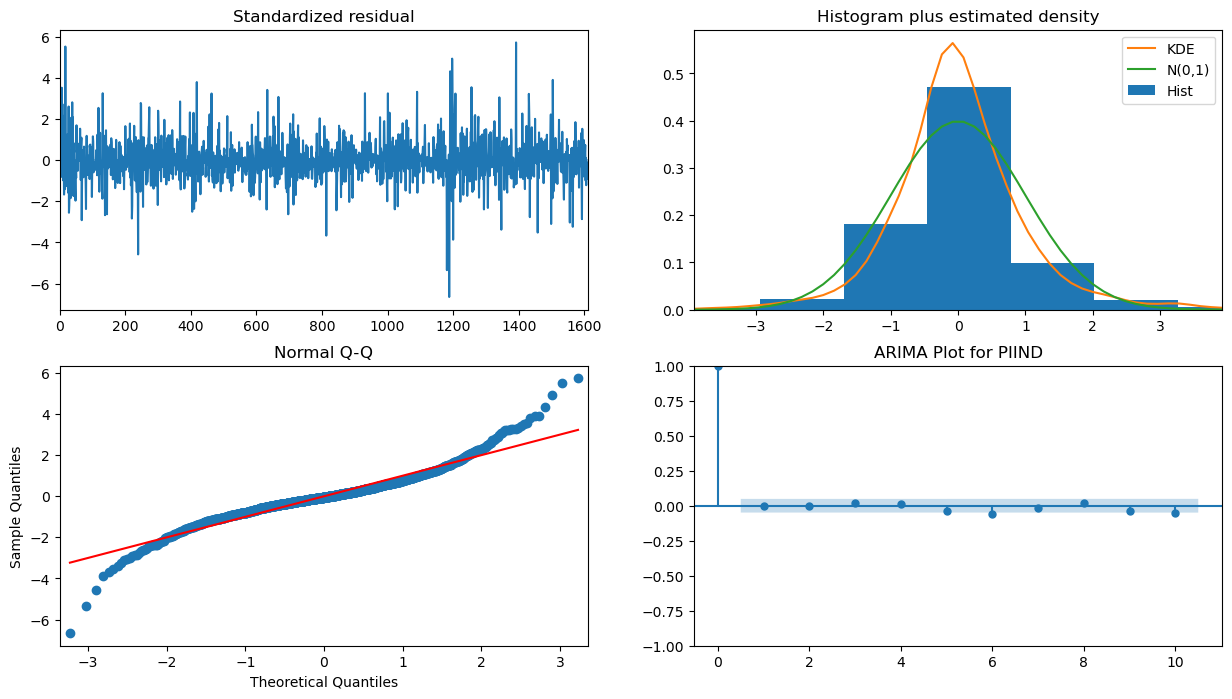

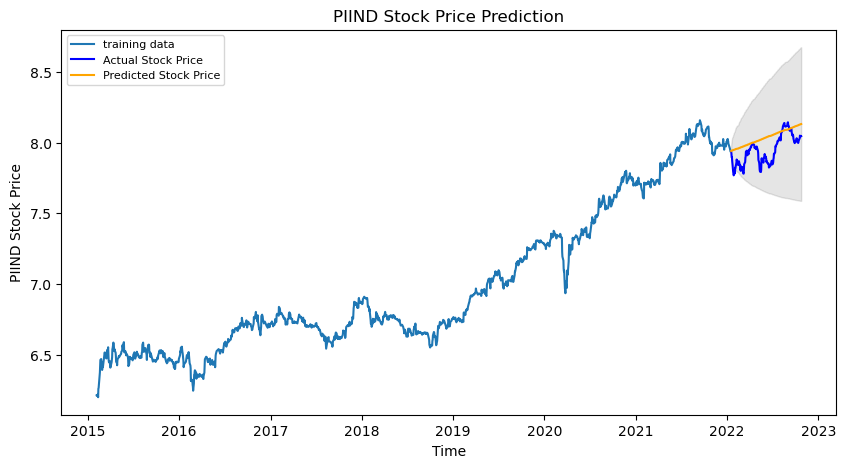

ARIMA Summary for ASIANPAINT
:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1614
Model:               SARIMAX(0, 1, 1)   Log Likelihood                4513.292
Date:                Wed, 30 Nov 2022   AIC                          -9020.585
Time:                        04:03:42   BIC                          -9004.427
Sample:                             0   HQIC                         -9014.587
                               - 1614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.000      2.137      0.033     7.2e-05       0.002
ma.L1          0.0988      0.014      6.847      0.000       0.071       0.127
sigma2         0.0002

/opt/conda/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


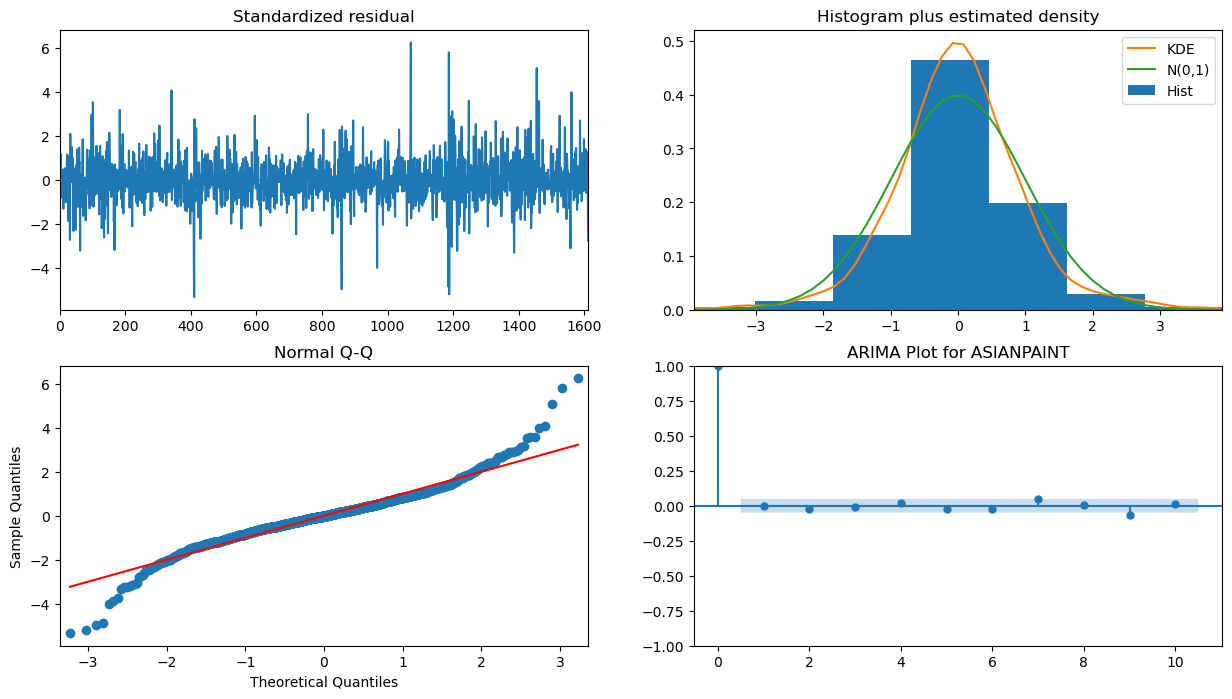

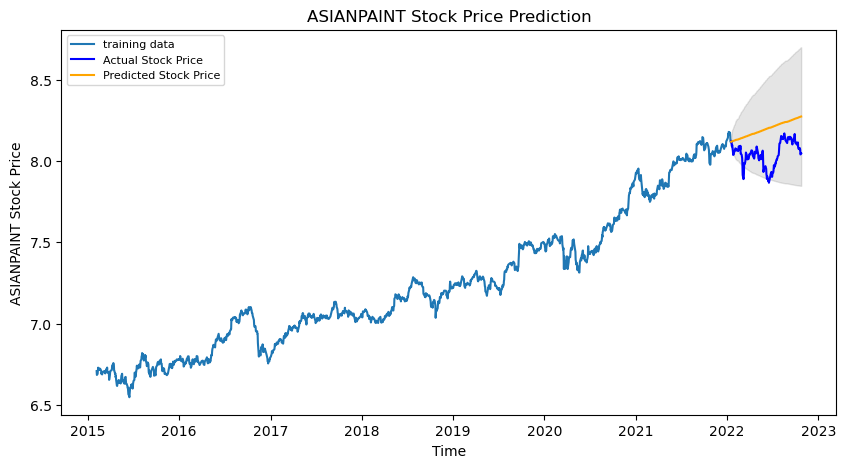

In [106]:
for company in top_companies_per_sector:
    df_log = np.log(top_companies_df[top_companies_df['company'] == company].set_index('day')['avg(sma10)'])
    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print('ARIMA Summary for {}\n: {}'.format(company,model_autoARIMA.summary()))
    model_autoARIMA.plot_diagnostics(figsize=(15,8))
    plt.title('ARIMA Plot for {}'.format(company))
    
    fc, conf = model_autoARIMA.predict(n_periods=len(test_data), index=test_data.index, return_conf_int=True)  
    fc_series = pd.DataFrame(list(zip(fc,test_data.index)), columns=['fitted', 'date']).set_index('date')
    lower_series = pd.Series(conf[:, 0], index=test_data.index)
    upper_series = pd.Series(conf[:, 1], index=test_data.index)
    
    #fc = fitted.forecast(len(test_data), alpha=0.05)
    
    #fc_series = pd.DataFrame(list(zip(fc,test_data.index)), columns=['fitted', 'date']).set_index('date')
    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training data')
    plt.plot(test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
    plt.title('{} Stock Price Prediction'.format(company))
    plt.xlabel('Time')
    plt.ylabel('{} Stock Price'.format(company))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()